# Taxi! Taxi! - Anomaly Detection in Unlabeled, Time-Series NYC Taxi Data

__Contents__
1. Data Preparation
2. Exploratory Data Analysis
    1. Initial Plots
    2. Aggregate (Daily, Monthly, Comparison)
    3. Distribution Analysis
    4. Outlier Identification
3. Feature Engineering
4. Final Data Preparation
5. Evaluation
    1. PCA Visualization
    2. t-SNE Visualization
6. Modeling (Hyperparameter Tuning)
    1. OneClassSVM
    2. DBSCAN
    3. Autoencoder
7. Feature Importance using Random Forest

---
# 1. Data Preparation

In [2]:
# Package Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
# Feature Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Evaluation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Models
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
# Autoencoder
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
# Feature Importance
from sklearn.ensemble import RandomForestClassifier

Data sourced from NYC Open Data.

* [Data Description](https://data.cityofnewyork.us/Transportation/2019-Yellow-Taxi-Trip-Data/2upf-qytp/about_data)
* [Download Link](https://data.cityofnewyork.us/api/views/2upf-qytp/rows.csv?accessType=DOWNLOAD&api_foundry=true)

Original file was 84.4M records and 8 GB. This was impractical to load using API. Instead, file was downloaded locally.

In [3]:
df_full_data = pd.read_csv('2019_Yellow_Taxi_Trip_Data.csv', nrows=1000)
df_full_data.to_csv('2019_Yellow_Taxi_Trip_Data_Reduced.csv',index=False)
df_full_data.head(2)

VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  passenger_count  \
0         1  01/01/2019 12:46:40 AM  01/01/2019 12:53:20 AM                1   
1         1  01/01/2019 12:59:47 AM  01/01/2019 01:18:59 AM                1   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            1.5           1                  N           151           239   
1            2.6           1                  N           239           246   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1          7.0    0.5      0.5        1.65           0.0   
1             1         14.0    0.5      0.5        1.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  
0                    0.3          9.95                   NaN  
1                    0.3         16.30                   NaN

File was still too large to load directly into Pandas dataframe. Instead, file was imported into PostgreSQL database for preprocessing.

Focus of project was identifying anomalies in NYC Taxi volume binned by each hour throughout the entire year. As such, preprocessing dropped all features except pickup time. The pickup time timestamp was decomposed into basic time features (hour, day, weekday, month) which were then aggregated to count number of trips each hour throughout the year.

In [410]:
### SQL Preprocessing

## 1. Create table

# CREATE TABLE nyc_data (
# 	VendorID		        NUMERIC,
# 	tpep_pickup_datetime	TIMESTAMP,
# 	tpep_dropoff_datetime	TIMESTAMP,
# 	passenger_count		    NUMERIC,
# 	trip_distance		    NUMERIC,
# 	Ratecodeid		        NUMERIC,
# 	store_and_fwd_flag	VARCHAR(80),
# 	PULocationID		NUMERIC,
# 	DOLocationID		NUMERIC,
# 	payment_type		NUMERIC,
# 	fare_amount		    NUMERIC,
# 	extra			    NUMERIC,
# 	mta_tax			    NUMERIC,
# 	tip_amount		    NUMERIC,
# 	tolls_amount		NUMERIC,
# 	improvement_surcharge	NUMERIC,
# 	total_amount		    NUMERIC,
# 	congestion_surcharge	VARCHAR(80)
# );

## 2. Import downloaded file from within Postgres

## 3. Decompose date into components - custom season label
# SELECT tpep_pickup_datetime AS datetime,
#     EXTRACT(HOUR FROM tpep_pickup_datetime) AS hour,
#     EXTRACT(DAY FROM tpep_pickup_datetime) AS day,
#     EXTRACT(dow FROM tpep_pickup_datetime) AS weekday,
#     EXTRACT(MONTH FROM tpep_pickup_datetime) AS month,
#     CASE
#         WHEN EXTRACT(MONTH FROM tpep_pickup_datetime) IN ('12','1','2') THEN '0' -- Winter
#         WHEN EXTRACT(MONTH FROM tpep_pickup_datetime) IN ('3','4','5') THEN '1' -- Spring
#         WHEN EXTRACT(MONTH FROM tpep_pickup_datetime) IN ('6','7','8') THEN '2' -- Winter
#         WHEN EXTRACT(MONTH FROM tpep_pickup_datetime) IN ('9','10','11') THEN '3' -- Winter
#     END AS season   
# INTO nyc_data_decomposed
# FROM nyc_data
# WHERE EXTRACT(YEAR FROM tpep_pickup_datetime) = 2019 # isolate 2019

## 4. Aggregate Hours
# CREATE TABLE nyc_data_aggregate AS
# 	SELECT month, day, hour, COUNT(datetime), weekday, season
# 	FROM nyc_data_decomposed
# 	GROUP BY season, month, day, weekday, hour
# 	ORDER BY month, day, hour

## 5. Export to file
# SELECT * FROM nyc_data_aggregate

The resulting file is then imported into Python for further processing. 

In [411]:
# File Import
df_hour_agg = pd.read_csv('2019_Yellow_Taxi_Trip_Data_Hour_Aggregated.csv')
df_hour_agg['datetime'] = pd.to_datetime({'year':2019,'month':df_hour_agg.month, 'day':df_hour_agg.day, 'hour':df_hour_agg.hour})
df_hour_agg.head(2)

month  day  hour  count  weekday  season            datetime
0      1    1     0  13428        2       0 2019-01-01 00:00:00
1      1    1     1  15444        2       0 2019-01-01 01:00:00

---
# 2. Exploratory Data Analysis

__Contents__:

2. Exploratory Data Analysis
    1. Initial Plots
    2. Aggregate (Daily, Monthly, Comparison)
    3. Distribution Analysis
    4. Outlier Identification

## 2.1 Initial Plots
Below are plots of the hourly aggregates plotted across the year and for the month of December.

Note daily variation (high during the day, low at night), weekly variation (low on weekends, high during week), and anomalies around July, Late November, and Christmas.

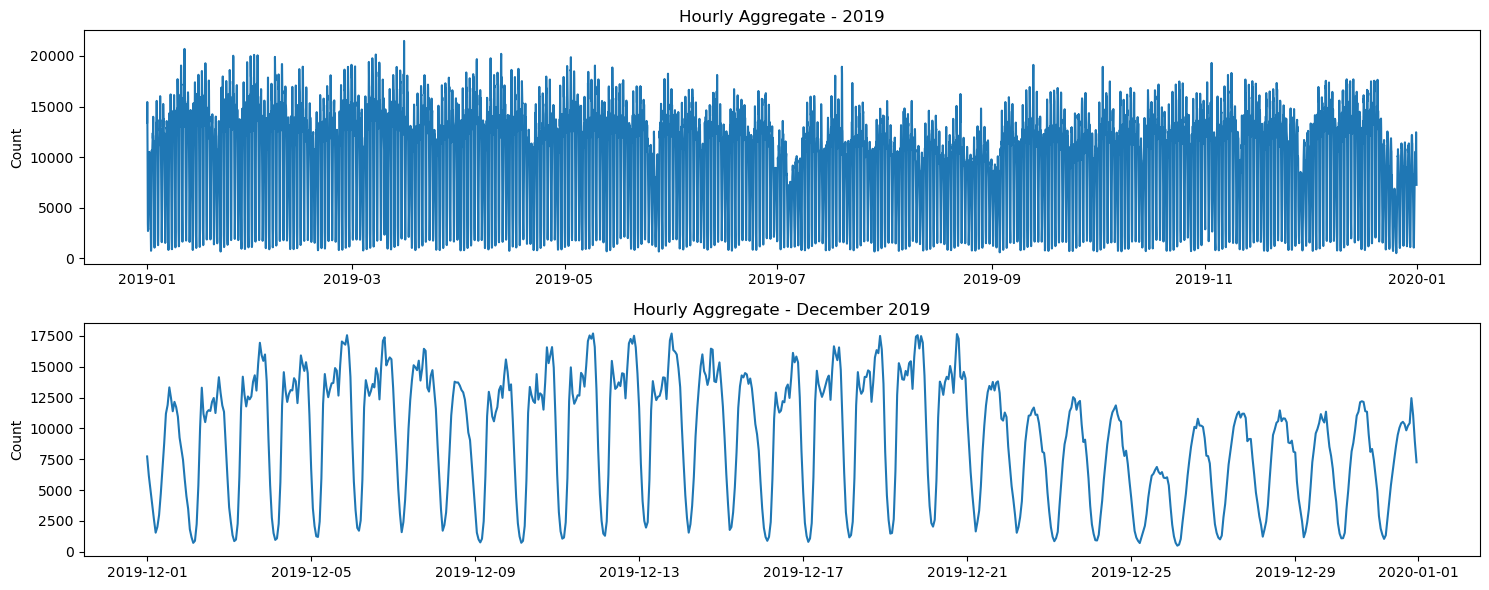

In [412]:
fig,axes = plt.subplots(2,1,figsize=(15,6))
axes[0].plot('datetime', 'count', data=df_hour_agg,)
axes[0].set_title("Hourly Aggregate - 2019")
axes[0].set_ylabel("Count")
axes[1].plot('datetime', 'count', data=df_hour_agg[df_hour_agg.month == 12])
axes[1].set_title("Hourly Aggregate - December 2019")
axes[1].set_ylabel("Count")
plt.tight_layout()

## 2.2 Aggregates (Daily, Monthly, Comparison)
Aggregating the data further into daily and monthly aggregates can help reveal longer trends.

In [413]:
## Daily aggregate
df_day_agg = df_hour_agg.groupby(['month','day']).agg({'count': 'sum', 'season': 'first','datetime': 'first','weekday': 'first'}).reset_index()
df_day_agg.head(1)

month  day   count  season   datetime  weekday
0      1    1  189035       0 2019-01-01        2

In [414]:
## Monthly aggregate
df_month_agg = df_day_agg.groupby(['month']).agg({'count': 'sum', 'season': 'first'}).reset_index()
df_month_agg['datetime'] = pd.to_datetime({'year':2019,'month':df_month_agg.month, 'day':15})
df_month_agg.head(1)

month    count  season   datetime
0      1  7667565       0 2019-01-15

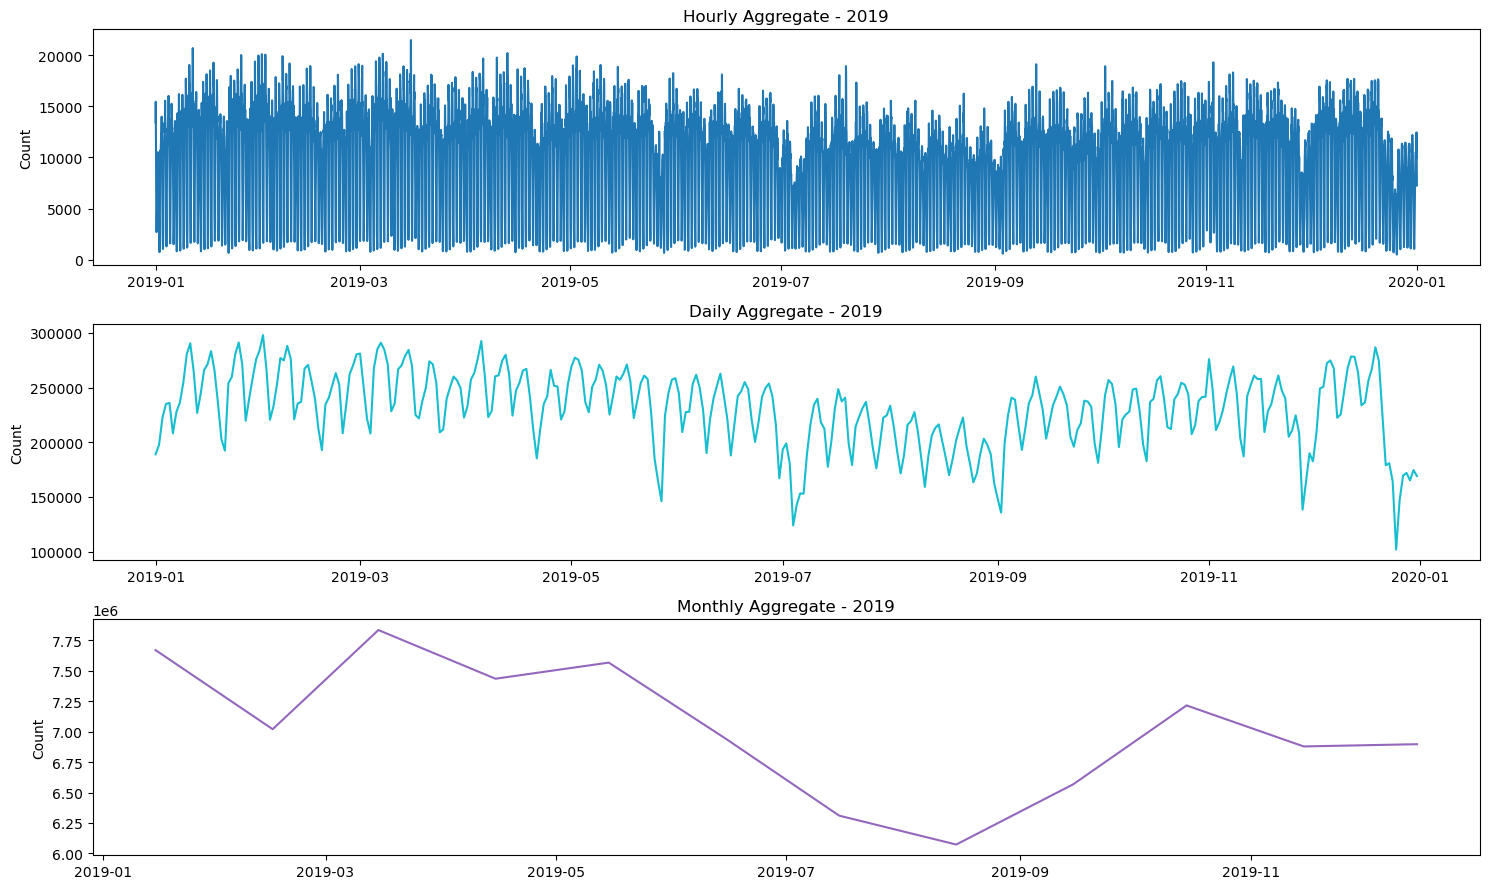

In [415]:
fig,axes = plt.subplots(3,1,figsize=(15,9))
axes[0].plot('datetime', 'count', data=df_hour_agg,)
axes[0].set_title("Hourly Aggregate - 2019")
axes[0].set_ylabel("Count")
axes[1].plot('datetime', 'count', data=df_day_agg, color='tab:cyan')
axes[1].set_title("Daily Aggregate - 2019")
axes[1].set_ylabel("Count")
axes[2].plot('datetime', 'count', data=df_month_agg, color='tab:purple')
axes[2].set_title("Monthly Aggregate - 2019")
axes[2].set_ylabel("Count")
plt.tight_layout()

## 2.3 Distribution Analysis
Next we can consider the distribution of the hourly and daily aggregates.

In [416]:
## Distribution Analysis

# Mapping proper day of the week labels 
day_mapping = {0: 'Su', 1: 'M', 2: 'Tu', 3: 'W', 4: 'Th', 
               5: 'F', 6: 'Sa', }
df_hour_agg['weekday_name'] = df_hour_agg['weekday'].map(day_mapping)
df_day_agg['weekday_name'] = df_day_agg['weekday'].map(day_mapping)
df_day_agg.head()

month  day   count  season   datetime  weekday weekday_name
0      1    1  189035       0 2019-01-01        2           Tu
1      1    2  197852       0 2019-01-02        3            W
2      1    3  222879       0 2019-01-03        4           Th
3      1    4  235053       0 2019-01-04        5            F
4      1    5  236041       0 2019-01-05        6           Sa

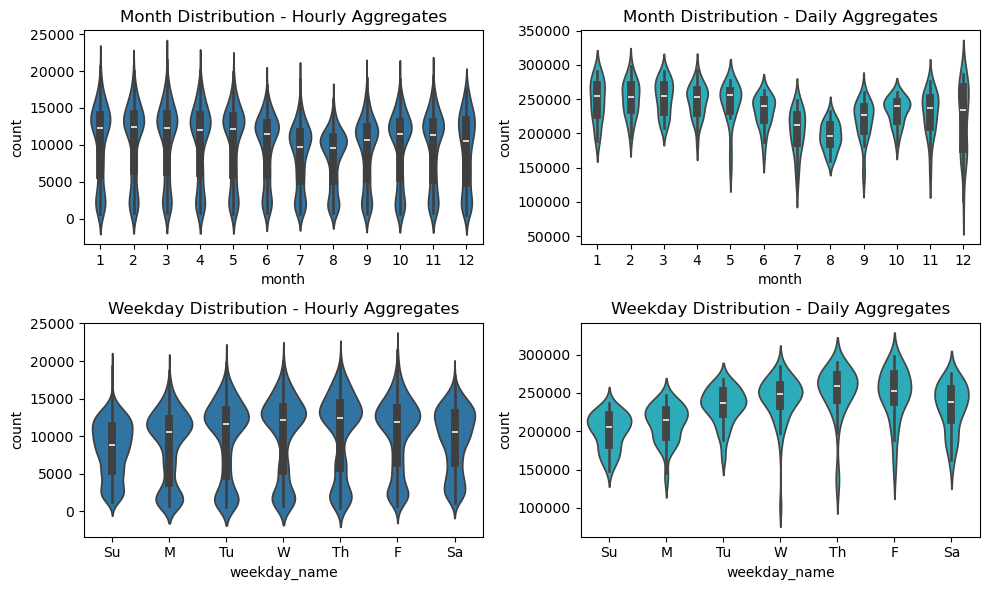

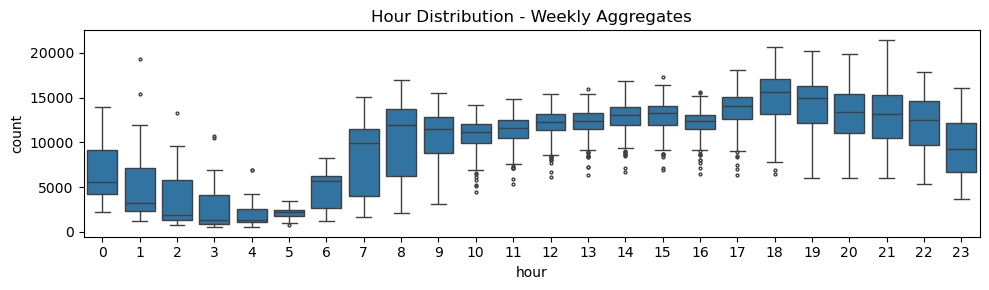

In [417]:
## Plotting

fig, axes = plt.subplots(2,2,figsize=(10,6))
# 2 columns: hourly, daily aggregates
# 2 rows: month, weekday 

## Month Row
# Hour Aggregate Column
sns.violinplot(data = df_hour_agg, x='month', y='count', ax=axes[0,0])
axes[0,0].set_title("Month Distribution - Hourly Aggregates")
# Day Aggregate Column
sns.violinplot(data = df_day_agg, x='month', y='count', ax=axes[0,1], color='tab:cyan')
axes[0,1].set_title("Month Distribution - Daily Aggregates")

## Weekday Row
# Hour Aggregate Column
sns.violinplot(data = df_hour_agg, x='weekday_name', y='count', ax=axes[1,0],
              order=['Su','M', 'Tu', 'W', 'Th', 'F', 'Sa'])
axes[1,0].set_title("Weekday Distribution - Hourly Aggregates")
# Day Aggregate Column
sns.violinplot(data = df_day_agg, x='weekday_name', y='count', ax=axes[1,1], color='tab:cyan',
              order=['Su','M', 'Tu', 'W', 'Th', 'F', 'Sa'])
axes[1,1].set_title("Weekday Distribution - Daily Aggregates")
plt.tight_layout()
plt.show()

# Hour Distribution - Hour Aggregate
plt.figure(figsize=(10,3))
sns.boxplot(data = df_hour_agg, x='hour', y='count', fliersize=2)
plt.title("Hour Distribution - Weekly Aggregates")
plt.tight_layout()
plt.show()

## 2.4 Outlier Identification
Since the intent of this analysis is to identify anomalies, we can use statistical anomalies as one means to evaluate our anomaly detection methods.

The below code identifies two types of anomalies:
1. _Hour Distribution Hour Anomalies_ - Which hour aggregates are statistical anomalies for their hour group.
2. _Weekday Distribution Day Anomalies_ - Which day aggregates are statistical anomalies for their weekday group.

In [418]:
# Hour Distribution Hour Anomalies
hour_outliers = []
for i in range(1,25): # For hour range
    hour_data = df_hour_agg[df_hour_agg.hour == i]['count']
    # Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR
    Q1 = hour_data.quantile(0.25)
    Q3 = hour_data.quantile(0.75)
    IQR = Q3 - Q1
    # Bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Identify outliers 
    hour_specific_outliers = hour_data[(hour_data < lower_bound) | (hour_data > upper_bound)]
    # Append the outliers to the list
    hour_outliers.extend(hour_specific_outliers.index)
print(f'Hour Anomalies: {len(hour_outliers)}, {round(100*len(hour_outliers)/len(df_hour_agg),2)}% of samples')

Hour Anomalies: 80, 0.91% of samples


In [419]:
# Weekday Distribution Day Anomalies
# Hour Distribution Hour Anomalies
day_outliers = []
for i in range(0,8): # For hour range
    weekday_data = df_day_agg[df_day_agg.weekday == i]['count']
    # Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR
    Q1 = weekday_data.quantile(0.25)
    Q3 = weekday_data.quantile(0.75)
    IQR = Q3 - Q1
    # Bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Identify outliers 
    weekday_specific_outliers = weekday_data[(weekday_data < lower_bound) | (weekday_data > upper_bound)]
    # Append the outliers to the list
    day_outliers.extend(weekday_specific_outliers.index)
print(f'Day Anomalies: {len(day_outliers)}, {round(100*len(day_outliers)/len(df_day_agg),2)}% of samples')

Day Anomalies: 12, 3.29% of samples


In [420]:
## Shifting IQR Outliers
# Need to shift outliers to new indexes since
# feature engineering, then removing null, then scaling data resets index.

hour_outliers_shifted = np.array(hour_outliers)-(13*24)
hour_outliers_shifted = hour_outliers_shifted[hour_outliers_shifted>0]

day_outliers_shifted = np.array(day_outliers)-(13)
day_outliers_shifted = day_outliers_shifted[day_outliers_shifted>0]

In [503]:
df_hour_agg.columns

Index(['month', 'day', 'hour', 'count', 'weekday', 'season', 'datetime',
       'weekday_name'],
      dtype='object')

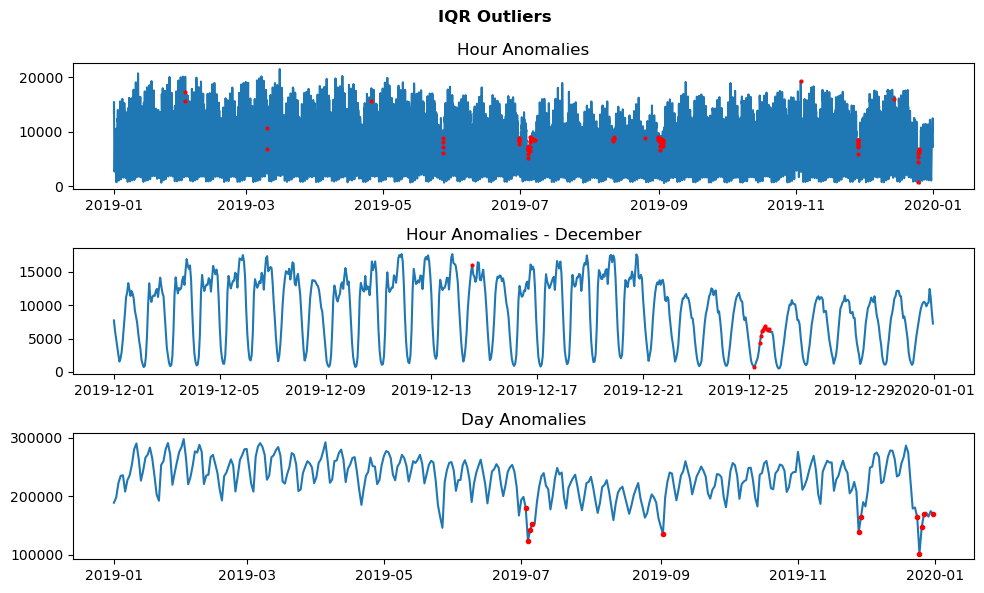

In [508]:
## Plotting outliers
def anomaly_plot(suptitle,hour_anomalies,day_anomalies):
    # Anomalies come in labeled under new index (with first 13 days of data removed)
    # To plot them correctly, we need to add them back.
    day_anomalies = np.array(day_anomalies)+13
    hour_anomalies = np.array(hour_anomalies)+(13*24)
    
    fig, axes = plt.subplots(3,1,figsize=(10,6))
    fig.suptitle(suptitle, fontsize=12, weight='bold')
    # Hour outliers
    axes[0].plot('datetime', 'count', data=df_hour_agg)
    axes[0].plot('datetime', 'count', 'o', data=df_hour_agg.iloc[hour_anomalies], color='red', markersize=2)
    axes[0].set_title("Hour Anomalies")
    # Hour outliers - December
    df_hour_agg_december = df_hour_agg[df_hour_agg['month'] == 12]
    hour_anomalies_array = np.array(hour_anomalies)
    hour_anomalies_december = hour_anomalies_array[(hour_anomalies_array >= df_hour_agg_december.index.min())]
    axes[1].plot('datetime', 'count', data=df_hour_agg_december)
    axes[1].plot('datetime', 'count', 'o', data=df_hour_agg_december.loc[hour_anomalies_december], color='red', markersize=2)
    axes[1].set_title("Hour Anomalies - December")
    # Day outliers
    axes[2].plot('datetime', 'count', data=df_day_agg)
    axes[2].plot('datetime', 'count', 'o', data=df_day_agg.iloc[day_anomalies], color='red', markersize=3)
    axes[2].set_title("Day Anomalies")
    plt.tight_layout()
    plt.show()

anomaly_plot(suptitle="IQR Outliers", hour_anomalies=hour_outliers_shifted, day_anomalies=day_outliers_shifted)

---
# 3. Feature Engineering

We need to develop features to capture the time-series context of the data. This includes:
* Rolling Averages
* Rate of Change
* Encoding cyclic features to represent position in day, week, year.

We will engineer features for hourly data and daily data.

In [422]:
## Hourly Feature Engineering

df_hour_final = df_hour_agg.copy()

# Rolling
df_hour_final['1_day_rolling_average'] = df_hour_final['count'].rolling(window=24).mean()
df_hour_final['7_day_rolling_average'] = df_hour_final['count'].rolling(window=24*7).mean()
df_hour_final['14_day_rolling_average'] = df_hour_final['count'].rolling(window=24*14).mean()

# Rate of Change
df_hour_final['1_day_rate_of_change'] = df_hour_final['1_day_rolling_average']/df_hour_final['1_day_rolling_average'].shift(24)
df_hour_final['7_day_rate_of_change'] = df_hour_final['7_day_rolling_average']/df_hour_final['7_day_rolling_average'].shift(24*7)

## Encoding cyclic features
df_hour_final['day_cycle'] = 0.5 * np.cos(2 * np.pi * df_hour_final['hour'] / 24) + 0.5
df_hour_final['week_cycle'] = 0.5 * np.cos(2 * np.pi * df_hour_final['weekday'] / 6) + 0.5
df_hour_final['year_month_cycle'] = 0.5 * np.cos(2 * np.pi * df_hour_final['month'] / 12) + 0.5
df_hour_final['year_season_cycle'] = 0.5 * np.cos(2 * np.pi * df_hour_final['season'] / 4) + 0.5
df_hour_final['year_hour_cycle'] = 0.5 * np.cos(2 * np.pi * np.arange(len(df_hour_final.day)) / (24*365)) + 0.5

month_cycle = []
month_lengths = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
for day, month in zip(df_hour_final.day,df_hour_final.month):
    month_length = month_lengths[month-1] # Month [1,12] but month_lengths index [0,11]
    month_cycle.append(0.5 * np.cos(2 * np.pi * day / month_length) + 0.5)
df_hour_final['month_cycle'] = month_cycle

df_hour_final.head(1)

month  day  hour  count  weekday  season   datetime weekday_name  \
0      1    1     0  13428        2       0 2019-01-01           Tu   

   1_day_rolling_average  7_day_rolling_average  14_day_rolling_average  \
0                    NaN                    NaN                     NaN   

   1_day_rate_of_change  7_day_rate_of_change  day_cycle  week_cycle  \
0                   NaN                   NaN        1.0        0.25   

   year_month_cycle  year_season_cycle  year_hour_cycle  month_cycle  
0          0.933013                1.0              1.0     0.989765

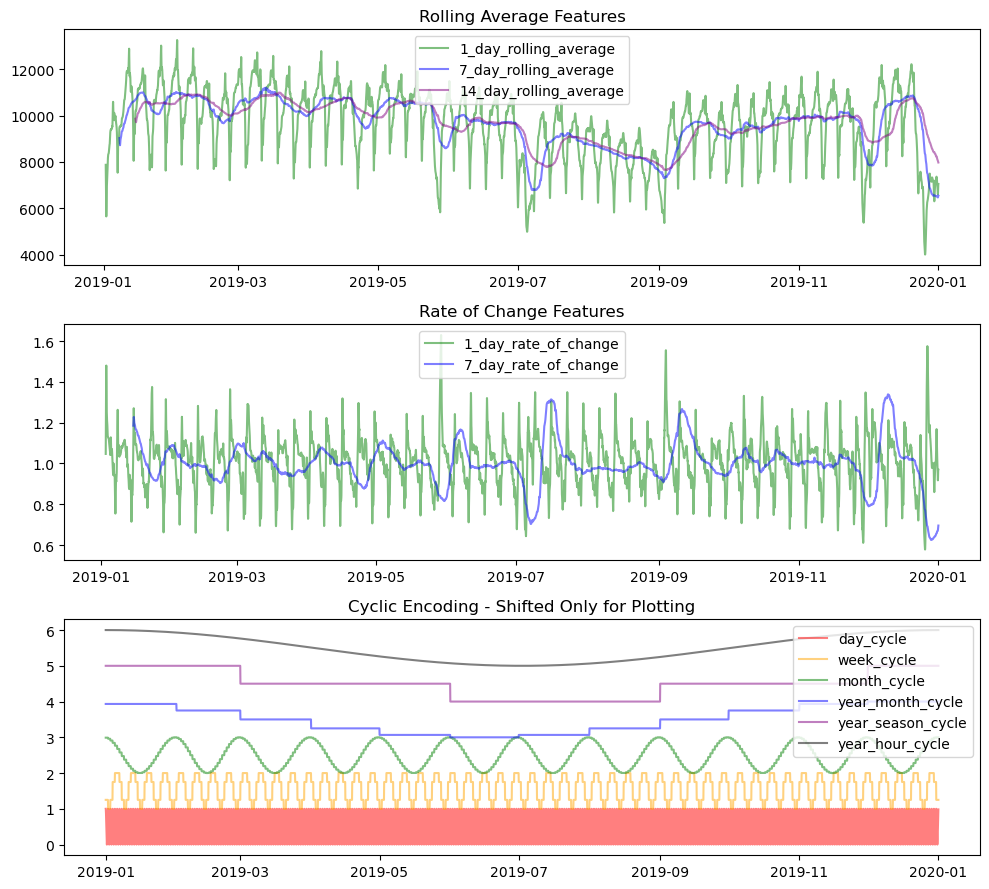

In [423]:
## Plotting Engineered Features - Hour

## Plotting Engineered Features
fig, axes = plt.subplots(3,1,figsize=(10,9))

## Rolling Averages
features = ['1_day_rolling_average','7_day_rolling_average','14_day_rolling_average']
colors = ['green','blue','purple']
for feature,color in zip(features,colors):
    axes[0].plot(df_hour_final['datetime'], df_hour_final[feature], label=feature, color=color, alpha=0.5)
    axes[0].legend(loc='upper center')
    axes[0].set_title('Rolling Average Features')

## Rate of Change
features = ['1_day_rate_of_change',	'7_day_rate_of_change']
colors = ['green','blue']
# shifts = [0,df_hour_final['count'].max(),2*df_hour_final['count'].max()]
for feature,color in zip(features,colors):
    axes[1].plot(df_hour_final['datetime'], df_hour_final[feature], label=feature, color=color, alpha=0.5)
    axes[1].legend(loc='upper center')
    axes[1].set_title('Rate of Change Features')
    
## Cyclic Encoding
features = ['day_cycle',  'week_cycle', 'month_cycle', 'year_month_cycle', 'year_season_cycle', 'year_hour_cycle']
colors = ['red','orange','green','blue','purple','black']
for i,feature,color in zip(range(len(features)),features,colors):
    # axes[2].plot(df_hour_final[(df_hour_final['month'] > 1) & (df_hour_final['month'] < 6)]['datetime'], df_hour_final[(df_hour_final['month'] > 1) & (df_hour_final['month'] < 6)][feature] + i, label=feature, color=color, alpha=0.5)
    axes[2].plot(df_hour_final['datetime'], df_hour_final[feature] + i, label=feature, color=color, alpha=0.5)
    axes[2].legend(loc='upper right')
    axes[2].set_title('Cyclic Encoding - Shifted Only for Plotting')

plt.tight_layout()
plt.show()   

In [424]:
## Relative Values
df_day_final = df_day_agg.copy()

# Rolling
df_day_final['7_day_rolling_average'] = df_day_final['count'].rolling(window=7).mean()
df_day_final['14_day_rolling_average'] = df_day_final['count'].rolling(window=14).mean()

# Rate of Change
df_day_final['1_day_rate_of_change'] = df_day_final['count']/df_day_final['count'].shift(1)
df_day_final['7_day_rate_of_change'] = df_day_final['7_day_rolling_average']/df_day_final['7_day_rolling_average'].shift(7)

## Encoding cyclic features
df_day_final['week_cycle'] = 0.5 * np.cos(2 * np.pi * df_day_final['weekday'] / 6) + 0.5
df_day_final['year_month_cycle'] = 0.5 * np.cos(2 * np.pi * df_day_final['month'] / 12) + 0.5
df_day_final['year_season_cycle'] = 0.5 * np.cos(2 * np.pi * df_day_final['season'] / 4) + 0.5
df_day_final['year_day_cycle'] = 0.5 * np.cos(2 * np.pi * np.arange(len(df_day_final.day)) / (365)) + 0.5

month_cycle = []
month_lengths = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
for day, month in zip(df_day_final.day,df_day_final.month):
    month_length = month_lengths[month-1] # Month [1,12] but month_lengths index [0,11]
    month_cycle.append(0.5 * np.cos(2 * np.pi * day / month_length) + 0.5)
df_day_final['month_cycle'] = month_cycle

df_day_final.head(1)

month  day   count  season   datetime  weekday weekday_name  \
0      1    1  189035       0 2019-01-01        2           Tu   

   7_day_rolling_average  14_day_rolling_average  1_day_rate_of_change  \
0                    NaN                     NaN                   NaN   

   7_day_rate_of_change  week_cycle  year_month_cycle  year_season_cycle  \
0                   NaN        0.25          0.933013                1.0   

   year_day_cycle  month_cycle  
0             1.0     0.989765

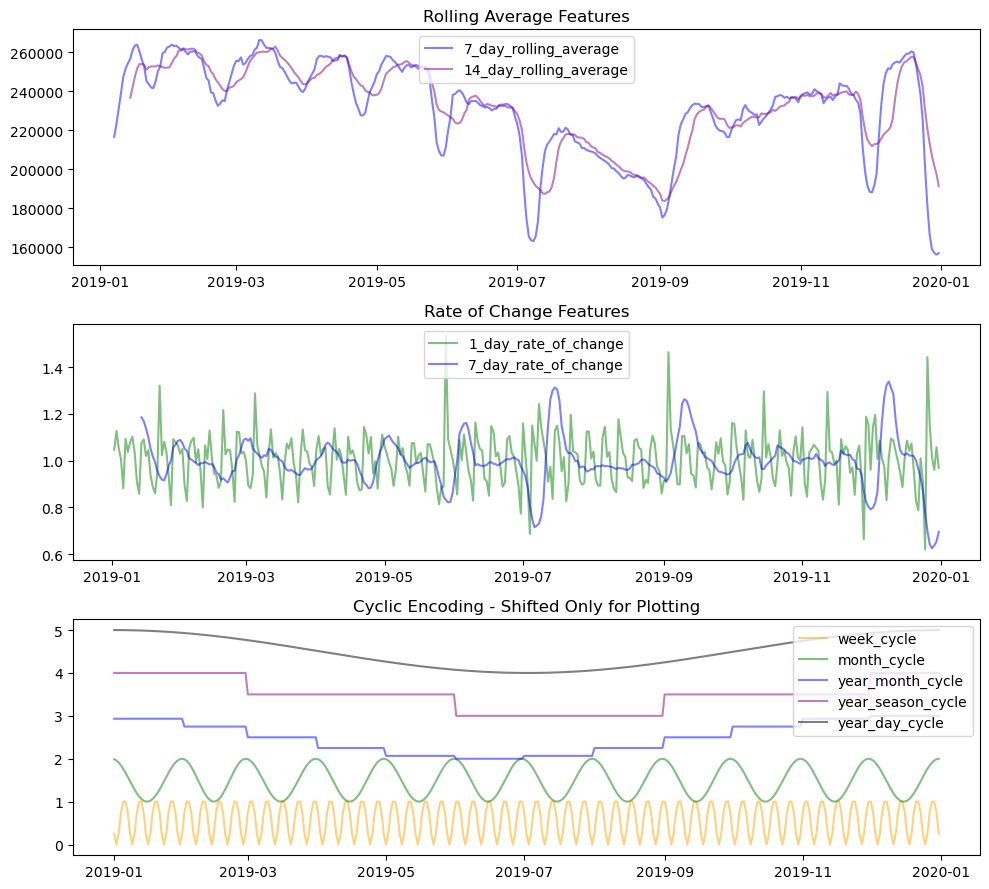

In [425]:
## Plotting Engineered Features - Hour

## Plotting Engineered Features
fig, axes = plt.subplots(3,1,figsize=(10,9))

## Rolling Averages
features = ['7_day_rolling_average','14_day_rolling_average']
colors = ['blue','purple']
for feature,color in zip(features,colors):
    axes[0].plot(df_day_final['datetime'], df_day_final[feature], label=feature, color=color, alpha=0.5)
    axes[0].legend(loc='upper center')
    axes[0].set_title('Rolling Average Features')

## Rate of Change
features = ['1_day_rate_of_change','7_day_rate_of_change']
colors = ['green','blue']
for feature,color in zip(features,colors):
    axes[1].plot(df_day_final['datetime'], df_day_final[feature], label=feature, color=color, alpha=0.5)
    axes[1].legend(loc='upper center')
    axes[1].set_title('Rate of Change Features')
    
## Cyclic Encoding
features = ['week_cycle', 'month_cycle', 'year_month_cycle', 'year_season_cycle', 'year_day_cycle']
colors = ['orange','green','blue','purple','black']
for i,feature,color in zip(range(len(features)),features,colors):
    axes[2].plot(df_day_final['datetime'], df_day_final[feature] + i, label=feature, color=color, alpha=0.5)
    axes[2].legend(loc='upper right')
    axes[2].set_title('Cyclic Encoding - Shifted Only for Plotting')

plt.tight_layout()
plt.show()   

---
# 4. Final Data Preparation
Since rolling average and rate of change calculations are based on past data, several data points at the start of the dataset have null values for these calculated features. These are removed before being fed to our algorithms.

In [426]:
# ## Remove Null Values
df_hour_final.dropna(inplace=True)
df_day_final.dropna(inplace=True)
# 
# df_hour_final.isnull().any(axis=1).sum()
# df_day_final.dropna(inplace=True)


Next remove the features which we won't use for our models.

In [427]:
## Remove unused features
# Hour
# print(df_hour_final.columns)
reduced_features_hour = ['count','1_day_rolling_average', '7_day_rolling_average', '14_day_rolling_average',
                         '1_day_rate_of_change', '7_day_rate_of_change',
                         'day_cycle', 'week_cycle', 'year_month_cycle', 
                         'year_season_cycle', 'year_hour_cycle', 'month_cycle']
df_hour_final = df_hour_final[reduced_features_hour]

# Day
# print(df_day_final.columns)
reduced_features_day = ['count','7_day_rolling_average', '14_day_rolling_average',
                         '1_day_rate_of_change', '7_day_rate_of_change',
                         'week_cycle', 'year_month_cycle', 
                         'year_season_cycle', 'year_day_cycle', 'month_cycle']
df_day_final = df_day_final[reduced_features_day]

Below are the final shapes of our data.

In [428]:
print(f'Hour: {df_hour_final.shape}')
print(f'Day: {df_day_final.shape}')

Hour: (8424, 12)
Day: (352, 10)


Finally we need to scale the data to work best in our algorithms. We will create both standardized scaling assuming normal distributions and min-max scaling.

In [429]:
## Scaling datasets

# Standard
df_hour_standard = StandardScaler().fit_transform(df_hour_final)
df_day_standard = StandardScaler().fit_transform(df_day_final)

# MinMax Scaler
df_hour_min_max = MinMaxScaler().fit_transform(df_hour_final)
df_day_min_max = MinMaxScaler().fit_transform(df_day_final)

---
# 5. Evaluation

Before modeling, we will pre-visualize the separability of our data. We will evaluate PCA which assumes linearly separable components, and use t-SNE to visual more complex components.

## 5.1 PCA

### 5.1.1 PCA - # of Components
PCA can provide an initial guess at the latent feature space in the autoencoder.

In [430]:
## Determine number of latent features for autoencoder
pca_90_hour = PCA(n_components = 0.9, svd_solver = 'full').fit(df_hour_min_max)
pca_90_day = PCA(n_components = 0.9, svd_solver = 'full').fit(df_day_min_max)
print(f'PCA Components for 90% Explained Variance - Hour: {pca_90_hour.n_components_}')
hour_latent_dim = pca_90_hour.n_components_
print(f'PCA Components for 90% Explained Variance - Day: {pca_90_day.n_components_}')
day_latent_dim = pca_90_day.n_components_

PCA Components for 90% Explained Variance - Hour: 6
PCA Components for 90% Explained Variance - Day: 4


We can also plot the cumulative explained variance and scree plots to show how PCA captures variance with additional components.

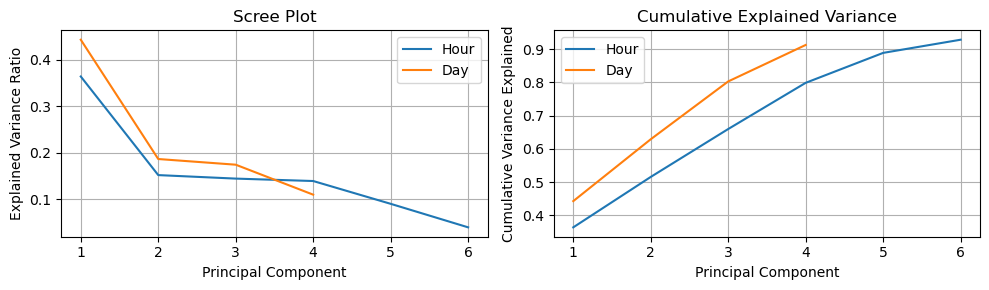

In [431]:
## Explained Variance
explained_variance_ratio_hour = pca_90_hour.explained_variance_ratio_
explained_variance_ratio_day = pca_90_day.explained_variance_ratio_
## Cumulative Variance
cumulative_variance_hour = pca_90_hour.explained_variance_ratio_.cumsum()
cumulative_variance_day = pca_90_day.explained_variance_ratio_.cumsum()

fig, axes = plt.subplots(1,2,figsize=(10,3))

# Plot scree plot
axes[0].set_title("Scree Plot")
axes[0].set_xlabel("Principal Component")
axes[0].set_ylabel("Explained Variance Ratio")
axes[0].plot(range(1, len(explained_variance_ratio_hour) + 1), explained_variance_ratio_hour, label='Hour')
axes[0].plot(range(1, len(explained_variance_ratio_day) + 1), explained_variance_ratio_day, label='Day')
axes[0].grid()
axes[0].legend()

# Plot cumulative explained variance
axes[1].set_title("Cumulative Explained Variance")
axes[1].set_xlabel("Principal Component")
axes[1].set_ylabel("Cumulative Variance Explained")
axes[1].plot(range(1, len(cumulative_variance_hour) + 1), cumulative_variance_hour, label='Hour')
axes[1].plot(range(1, len(cumulative_variance_day) + 1), cumulative_variance_day, label="Day")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

We can also use PCA to understand the explanation in variance for our system.

In [432]:
hour_eigen = pd.DataFrame({'Feature':df_hour_final.columns,"Hour PC 1":pca_90_hour.components_[0]})
day_eigen = pd.DataFrame({'Feature':df_day_final.columns,"Day PC 1":pca_90_day.components_[0]})
eigenvalues = pd.merge(hour_eigen,day_eigen, on='Feature', how='outer')
eigenvalues['Max PC Exp. Var'] = eigenvalues[['Hour PC 1','Day PC 1']].max(axis=1) 
eigenvalues.sort_values("Max PC Exp. Var", ascending=False)

Feature  Hour PC 1  Day PC 1  Max PC Exp. Var
10         year_hour_cycle   0.566957       NaN         0.566957
9           year_day_cycle        NaN  0.564387         0.564387
12       year_season_cycle   0.540705  0.539614         0.540705
11        year_month_cycle   0.534085  0.529259         0.534085
0   14_day_rolling_average   0.239962  0.247640         0.247640
4    7_day_rolling_average   0.176392  0.186549         0.186549
5                    count   0.046634  0.106633         0.106633
2    1_day_rolling_average   0.091062       NaN         0.091062
3     7_day_rate_of_change   0.009671  0.011007         0.011007
1     1_day_rate_of_change   0.003383  0.002379         0.003383
6                day_cycle  -0.006488       NaN        -0.006488
8               week_cycle  -0.013189 -0.017942        -0.013189
7              month_cycle  -0.038307 -0.047150        -0.038307

### 5.1.2 PCA Visualization
Visualize our distribution in 2 dimensions using 2 principal components.

#### __Standard Data__ 

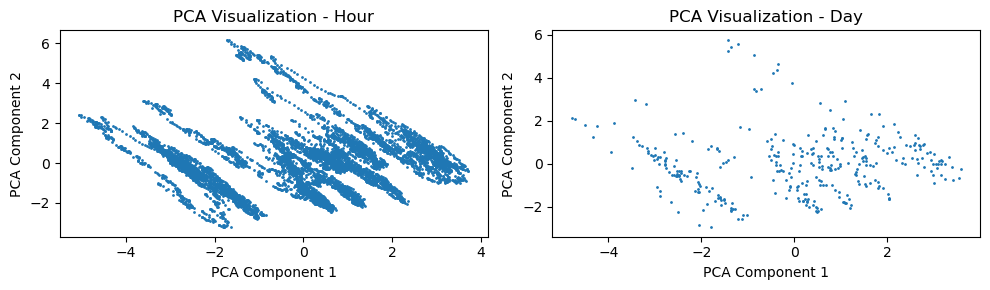

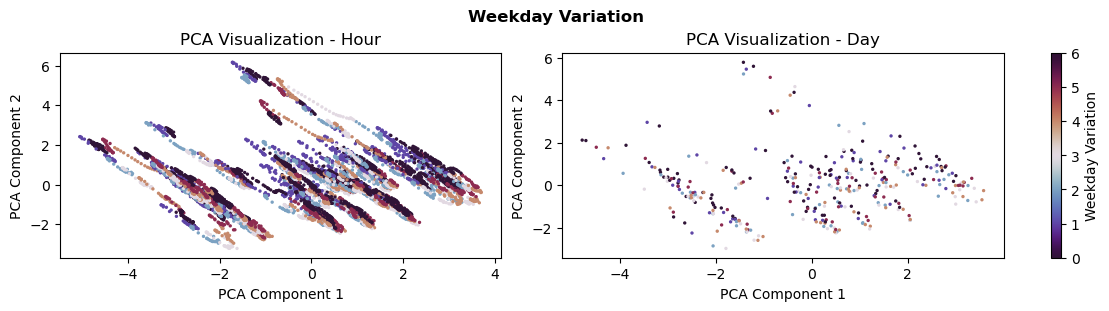

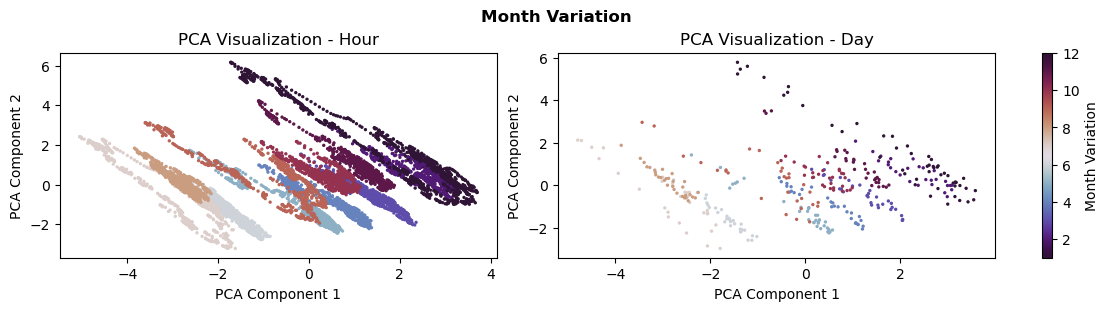

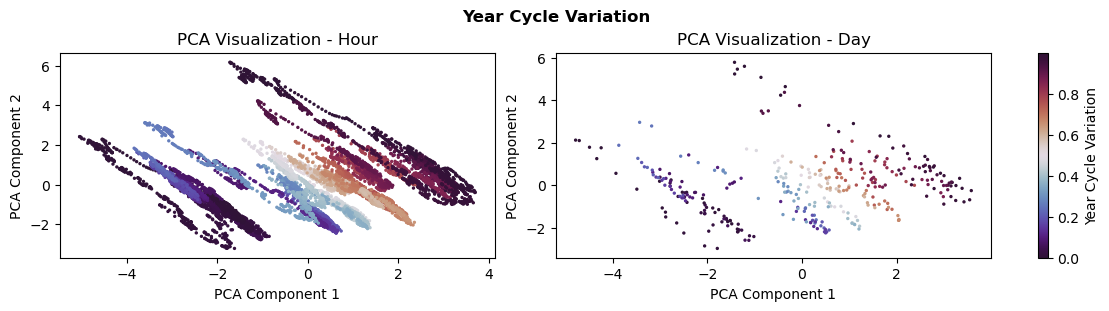

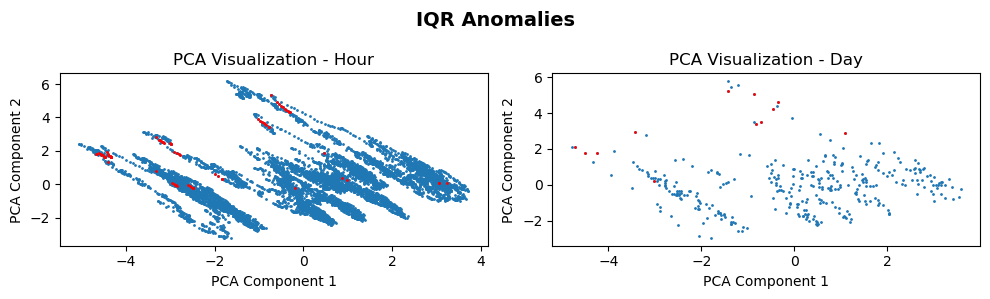

In [433]:
## PCA visualization
PCA_standard_2_comp = PCA(n_components = 2, svd_solver = 'full')
df_PCA_standard_hour = PCA_standard_2_comp.fit_transform(df_hour_standard)
df_PCA_standard_day = PCA_standard_2_comp.fit_transform(df_day_standard)

# Plot functions
def PCA_standard_Plot_Plain():
    fig, axes = plt.subplots(1,2,figsize=(10,3))
    # Hour
    axes[0].scatter(df_PCA_standard_hour[:, 0], df_PCA_standard_hour[:, 1],s=1) # c=labels
    axes[0].set_title("PCA Visualization - Hour")
    axes[0].set_xlabel("PCA Component 1")
    axes[0].set_ylabel("PCA Component 2")
    # Day
    axes[1].scatter(df_PCA_standard_day[:, 0], df_PCA_standard_day[:, 1],s=1) # c=labels
    axes[1].set_title("PCA Visualization - Day")
    axes[1].set_xlabel("PCA Component 1")
    axes[1].set_ylabel("PCA Component 2")
    plt.tight_layout()
    plt.show()

def PCA_standard_Plot_Color(suptitle='',color_param_hour='tab:blue',color_param_day='tab:blue'):
    fig, axes = plt.subplots(1,2,figsize=(11,3), constrained_layout=True)
    fig.suptitle(suptitle, fontsize=12, weight='bold')
    # Hour
    scatter_hour = axes[0].scatter(df_PCA_standard_hour[:, 0], df_PCA_standard_hour[:, 1],s=2,
                   c=color_param_hour, cmap='twilight_shifted') # c=labels
    axes[0].set_title("PCA Visualization - Hour")
    axes[0].set_xlabel("PCA Component 1")
    axes[0].set_ylabel("PCA Component 2")
    # Day
    scatter_day = axes[1].scatter(df_PCA_standard_day[:, 0], df_PCA_standard_day[:, 1],s=2,
                   c=color_param_day, cmap='twilight_shifted') # c=labels
    axes[1].set_title("PCA Visualization - Day")
    axes[1].set_xlabel("PCA Component 1")
    axes[1].set_ylabel("PCA Component 2") 
    fig.colorbar(scatter_hour,ax=axes, location='right').set_label(suptitle)
    plt.show()

def PCA_standard_Plot_Anomalies(suptitle, hour_anomalies,day_anomalies):
    ## Provide outliers as list of indexes, based on truncated index     
    fig, axes = plt.subplots(1,2,figsize=(10,3))
    fig.suptitle(suptitle,fontsize=14, weight='bold')
    # Hour
    axes[0].scatter(df_PCA_standard_hour[:, 0], df_PCA_standard_hour[:, 1],s=1) # Regular
    axes[0].scatter(df_PCA_standard_hour[hour_anomalies, 0], df_PCA_standard_hour[hour_anomalies, 1],s=1, c='red') # Anomalies
    axes[0].set_title("PCA Visualization - Hour")
    axes[0].set_xlabel("PCA Component 1")
    axes[0].set_ylabel("PCA Component 2")
    # Day
    axes[1].scatter(df_PCA_standard_day[:, 0], df_PCA_standard_day[:, 1],s=1) # Regular
    axes[1].scatter(df_PCA_standard_day[day_anomalies, 0], df_PCA_standard_day[day_anomalies, 1],s=1,c='red') # Anomalies
    axes[1].set_title("PCA Visualization - Day")
    axes[1].set_xlabel("PCA Component 1")
    axes[1].set_ylabel("PCA Component 2")
    plt.tight_layout()
    plt.show()

## Plotting
PCA_standard_Plot_Plain()

PCA_standard_Plot_Color(suptitle='Weekday Variation',color_param_hour=df_hour_agg.iloc[df_hour_final.index].weekday,color_param_day=df_day_agg.iloc[df_day_final.index].weekday)
PCA_standard_Plot_Color(suptitle='Month Variation',color_param_hour=df_hour_agg.iloc[df_hour_final.index].month,color_param_day=df_day_agg.iloc[df_day_final.index].month)
PCA_standard_Plot_Color(suptitle='Year Cycle Variation',color_param_hour=df_hour_final.year_hour_cycle,color_param_day=df_day_final.year_day_cycle)

PCA_standard_Plot_Anomalies(suptitle='IQR Anomalies', hour_anomalies=hour_outliers_shifted,day_anomalies=day_outliers_shifted)

#### __Min Max Normalized Data__ 

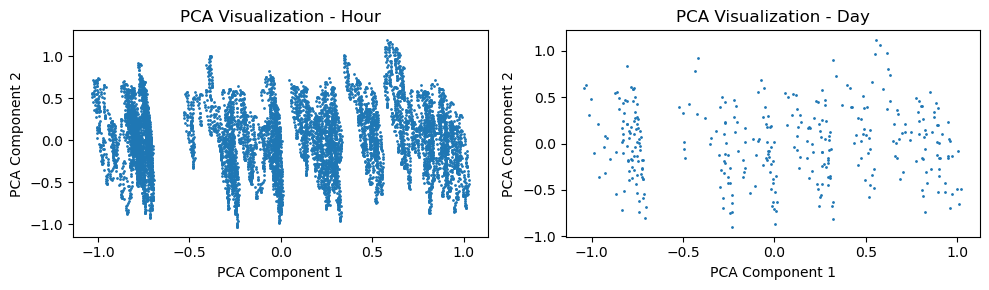

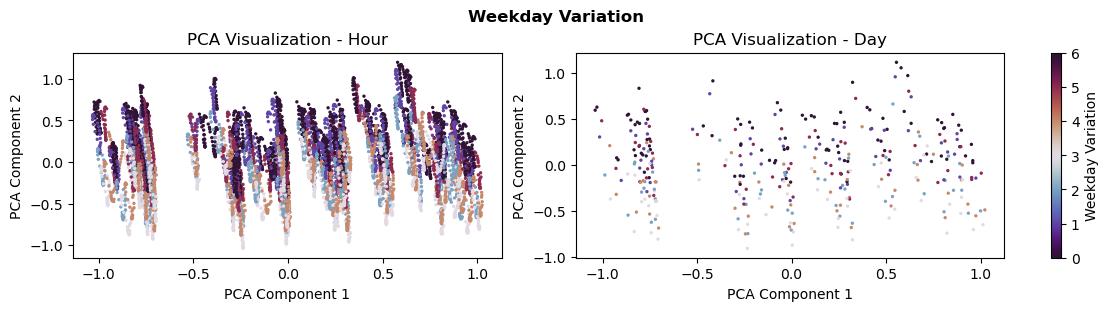

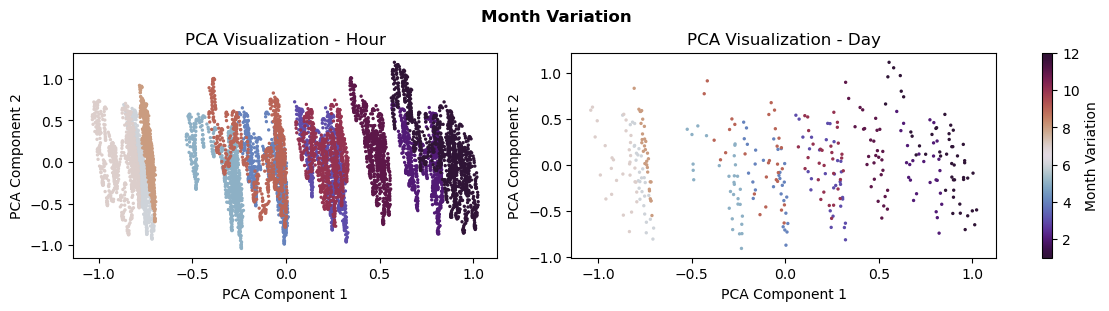

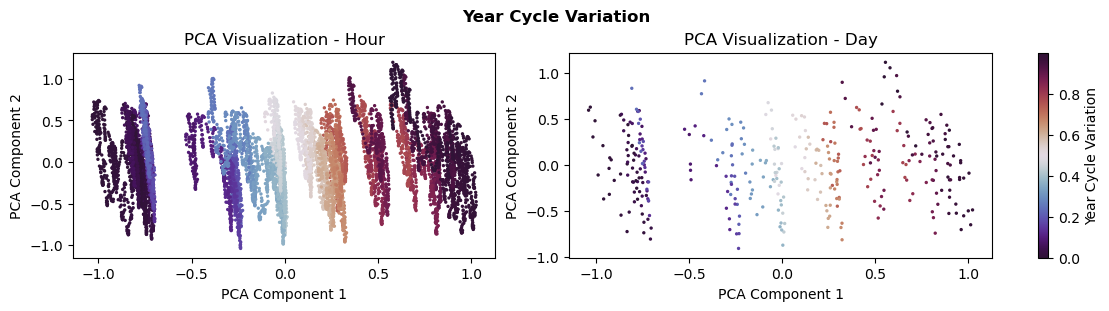

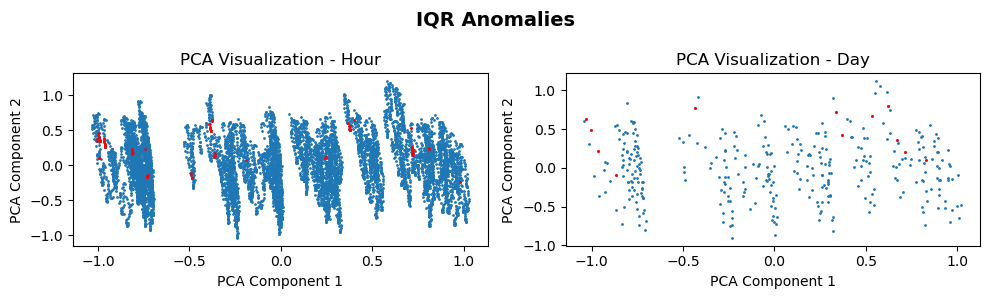

In [434]:
## PCA visualization
PCA_min_max_2_comp = PCA(n_components = 2, svd_solver = 'full')
df_PCA_min_max_hour = PCA_min_max_2_comp.fit_transform(df_hour_min_max)
df_PCA_min_max_day = PCA_min_max_2_comp.fit_transform(df_day_min_max)

# Plot functions
def PCA_min_max_Plot_Plain():
    fig, axes = plt.subplots(1,2,figsize=(10,3))
    # Hour
    axes[0].scatter(df_PCA_min_max_hour[:, 0], df_PCA_min_max_hour[:, 1],s=1) # c=labels
    axes[0].set_title("PCA Visualization - Hour")
    axes[0].set_xlabel("PCA Component 1")
    axes[0].set_ylabel("PCA Component 2")
    # Day
    axes[1].scatter(df_PCA_min_max_day[:, 0], df_PCA_min_max_day[:, 1],s=1) # c=labels
    axes[1].set_title("PCA Visualization - Day")
    axes[1].set_xlabel("PCA Component 1")
    axes[1].set_ylabel("PCA Component 2")
    plt.tight_layout()
    plt.show()

def PCA_min_max_Plot_Color(suptitle='',color_param_hour='tab:blue',color_param_day='tab:blue'):
    fig, axes = plt.subplots(1,2,figsize=(11,3), constrained_layout=True)
    fig.suptitle(suptitle, fontsize=12, weight='bold')
    # Hour
    scatter_hour = axes[0].scatter(df_PCA_min_max_hour[:, 0], df_PCA_min_max_hour[:, 1],s=2,
                   c=color_param_hour, cmap='twilight_shifted') # c=labels
    axes[0].set_title("PCA Visualization - Hour")
    axes[0].set_xlabel("PCA Component 1")
    axes[0].set_ylabel("PCA Component 2")
    # Day
    scatter_day = axes[1].scatter(df_PCA_min_max_day[:, 0], df_PCA_min_max_day[:, 1],s=2,
                   c=color_param_day, cmap='twilight_shifted') # c=labels
    axes[1].set_title("PCA Visualization - Day")
    axes[1].set_xlabel("PCA Component 1")
    axes[1].set_ylabel("PCA Component 2") 
    fig.colorbar(scatter_hour,ax=axes, location='right').set_label(suptitle)
    plt.show()

def PCA_min_max_Plot_Anomalies(suptitle, hour_anomalies,day_anomalies):
    ## Provide outliers as list of indexes using new index   
    fig, axes = plt.subplots(1,2,figsize=(10,3))
    fig.suptitle(suptitle,fontsize=14, weight='bold')
    # Hour
    axes[0].scatter(df_PCA_min_max_hour[:, 0], df_PCA_min_max_hour[:, 1],s=1) # Regular
    axes[0].scatter(df_PCA_min_max_hour[hour_anomalies, 0], df_PCA_min_max_hour[hour_anomalies, 1],s=1, c='red') # Anomalies
    axes[0].set_title("PCA Visualization - Hour")
    axes[0].set_xlabel("PCA Component 1")
    axes[0].set_ylabel("PCA Component 2")
    # Day
    axes[1].scatter(df_PCA_min_max_day[:, 0], df_PCA_min_max_day[:, 1],s=1) # Regular
    axes[1].scatter(df_PCA_min_max_day[day_anomalies, 0], df_PCA_min_max_day[day_anomalies, 1],s=1,c='red') # Anomalies
    axes[1].set_title("PCA Visualization - Day")
    axes[1].set_xlabel("PCA Component 1")
    axes[1].set_ylabel("PCA Component 2")
    plt.tight_layout()
    plt.show()

## Plotting
PCA_min_max_Plot_Plain()

PCA_min_max_Plot_Color(suptitle='Weekday Variation',color_param_hour=df_hour_agg.iloc[df_hour_final.index].weekday,color_param_day=df_day_agg.iloc[df_day_final.index].weekday)
PCA_min_max_Plot_Color(suptitle='Month Variation',color_param_hour=df_hour_agg.iloc[df_hour_final.index].month,color_param_day=df_day_agg.iloc[df_day_final.index].month)
PCA_min_max_Plot_Color(suptitle='Year Cycle Variation',color_param_hour=df_hour_final.year_hour_cycle,color_param_day=df_day_final.year_day_cycle)

PCA_min_max_Plot_Anomalies(suptitle='IQR Anomalies', hour_anomalies=hour_outliers_shifted,day_anomalies=day_outliers_shifted)

## 5.2 t-SNE Visualization
We can perform similar visualization using t-SNE, which better captures non-linearity.
### 5.2.1 Standard Data

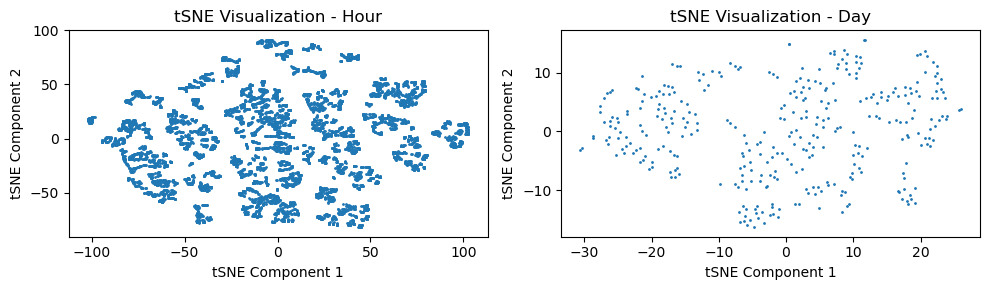

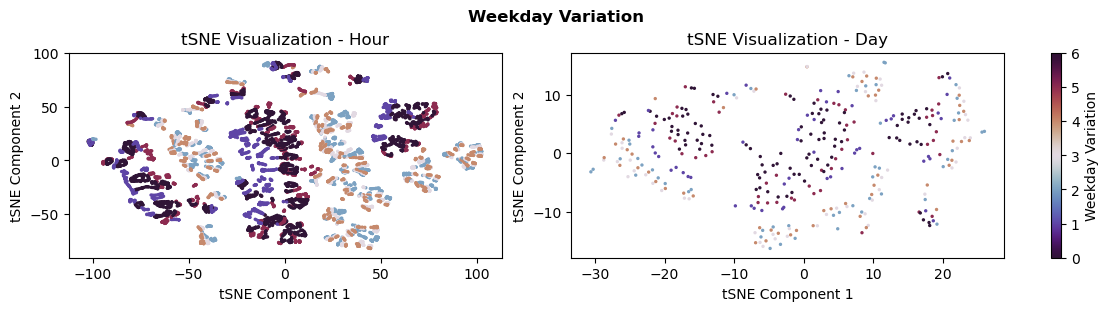

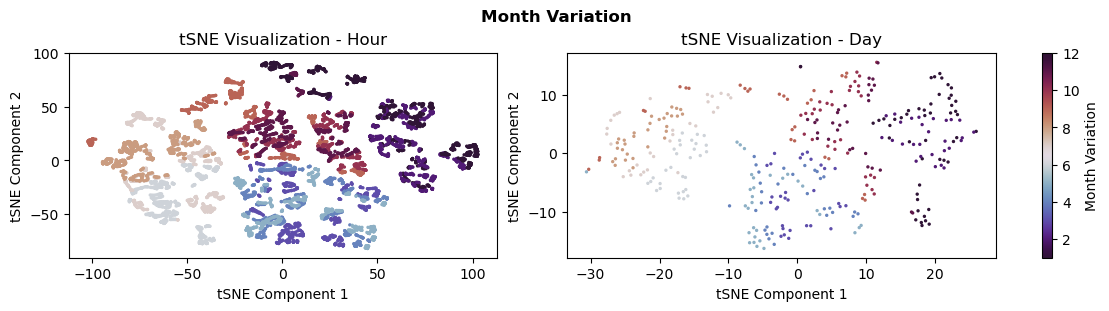

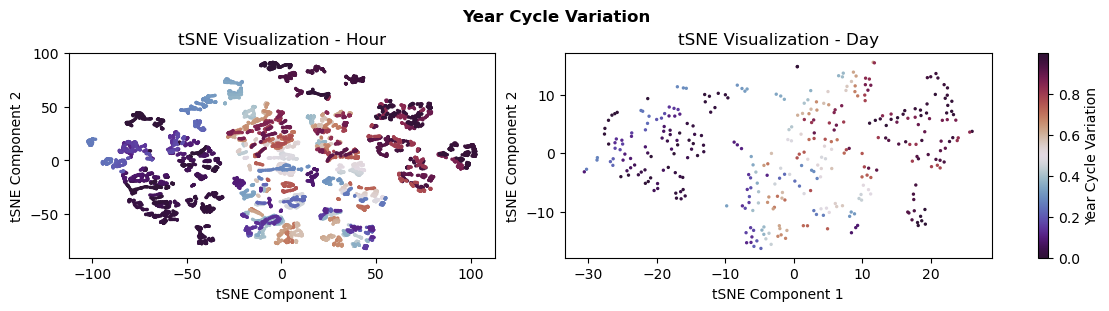

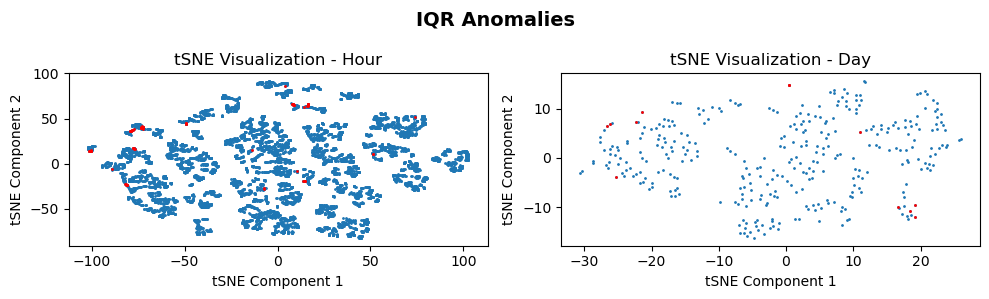

In [435]:
## t-SNE visualization
tSNE = TSNE(n_components=2, perplexity=30, random_state=42)
df_tSNE_standard_hour = tSNE.fit_transform(df_hour_standard)
df_tSNE_standard_day = tSNE.fit_transform(df_day_standard)

# Plot functions
def tSNE_standard_Plot_Plain():
    fig, axes = plt.subplots(1,2,figsize=(10,3))
    # Hour
    axes[0].scatter(df_tSNE_standard_hour[:, 0], df_tSNE_standard_hour[:, 1],s=1) # c=labels
    axes[0].set_title("tSNE Visualization - Hour")
    axes[0].set_xlabel("tSNE Component 1")
    axes[0].set_ylabel("tSNE Component 2")
    # Day
    axes[1].scatter(df_tSNE_standard_day[:, 0], df_tSNE_standard_day[:, 1],s=1) # c=labels
    axes[1].set_title("tSNE Visualization - Day")
    axes[1].set_xlabel("tSNE Component 1")
    axes[1].set_ylabel("tSNE Component 2")
    plt.tight_layout()
    plt.show()

def tSNE_standard_Plot_Color(suptitle='',color_param_hour='tab:blue',color_param_day='tab:blue'):
    fig, axes = plt.subplots(1,2,figsize=(11,3), constrained_layout=True)
    fig.suptitle(suptitle, fontsize=12, weight='bold')
    # Hour
    scatter_hour = axes[0].scatter(df_tSNE_standard_hour[:, 0], df_tSNE_standard_hour[:, 1],s=2,
                   c=color_param_hour, cmap='twilight_shifted') # c=labels
    axes[0].set_title("tSNE Visualization - Hour")
    axes[0].set_xlabel("tSNE Component 1")
    axes[0].set_ylabel("tSNE Component 2")
    # Day
    scatter_day = axes[1].scatter(df_tSNE_standard_day[:, 0], df_tSNE_standard_day[:, 1],s=2,
                   c=color_param_day, cmap='twilight_shifted') # c=labels
    axes[1].set_title("tSNE Visualization - Day")
    axes[1].set_xlabel("tSNE Component 1")
    axes[1].set_ylabel("tSNE Component 2") 
    fig.colorbar(scatter_hour,ax=axes, location='right').set_label(suptitle)
    plt.show()

def tSNE_standard_Plot_Anomalies(suptitle, hour_anomalies,day_anomalies):
    ## Provide outliers as list of indexes in new data
    fig, axes = plt.subplots(1,2,figsize=(10,3))
    fig.suptitle(suptitle,fontsize=14, weight='bold')
    # Hour
    axes[0].scatter(df_tSNE_standard_hour[:, 0], df_tSNE_standard_hour[:, 1],s=1) # Regular
    axes[0].scatter(df_tSNE_standard_hour[hour_anomalies, 0], df_tSNE_standard_hour[hour_anomalies, 1],s=1, c='red') # Anomalies
    axes[0].set_title("tSNE Visualization - Hour")
    axes[0].set_xlabel("tSNE Component 1")
    axes[0].set_ylabel("tSNE Component 2")
    # Day
    axes[1].scatter(df_tSNE_standard_day[:, 0], df_tSNE_standard_day[:, 1],s=1) # Regular
    axes[1].scatter(df_tSNE_standard_day[day_anomalies, 0], df_tSNE_standard_day[day_anomalies, 1],s=1,c='red') # Anomalies
    axes[1].set_title("tSNE Visualization - Day")
    axes[1].set_xlabel("tSNE Component 1")
    axes[1].set_ylabel("tSNE Component 2")
    plt.tight_layout()
    plt.show()

## Plotting
tSNE_standard_Plot_Plain()

tSNE_standard_Plot_Color(suptitle='Weekday Variation',color_param_hour=df_hour_agg.iloc[df_hour_final.index].weekday,color_param_day=df_day_agg.iloc[df_day_final.index].weekday)
tSNE_standard_Plot_Color(suptitle='Month Variation',color_param_hour=df_hour_agg.iloc[df_hour_final.index].month,color_param_day=df_day_agg.iloc[df_day_final.index].month)
tSNE_standard_Plot_Color(suptitle='Year Cycle Variation',color_param_hour=df_hour_final.year_hour_cycle,color_param_day=df_day_final.year_day_cycle)

tSNE_standard_Plot_Anomalies(suptitle='IQR Anomalies', hour_anomalies=hour_outliers_shifted,day_anomalies=day_outliers_shifted)

### 5.2.2 Min_Max Data

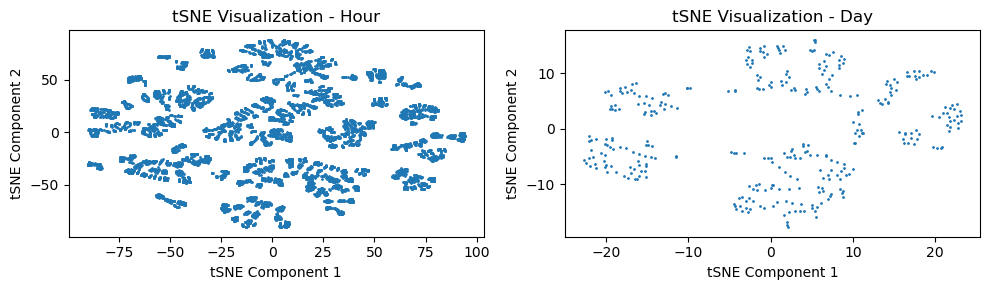

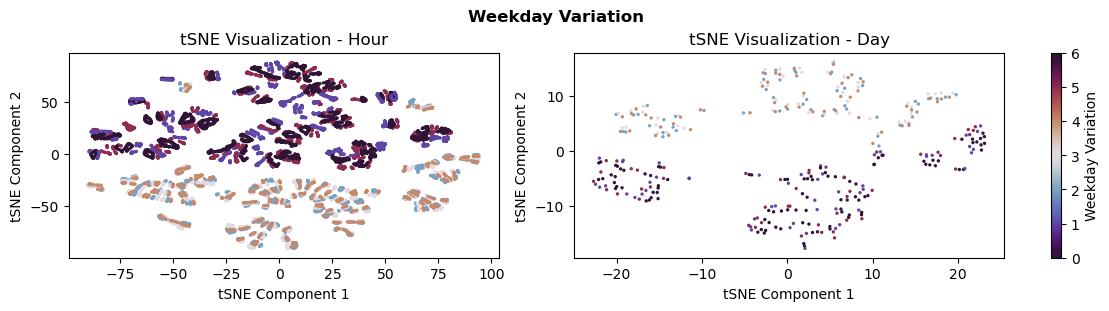

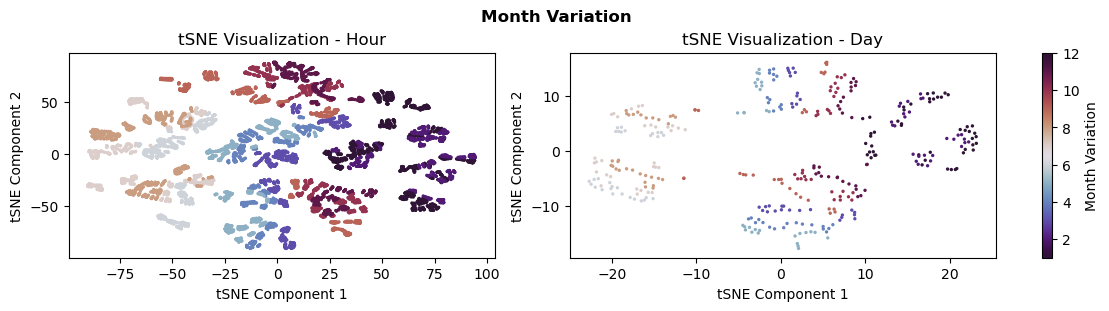

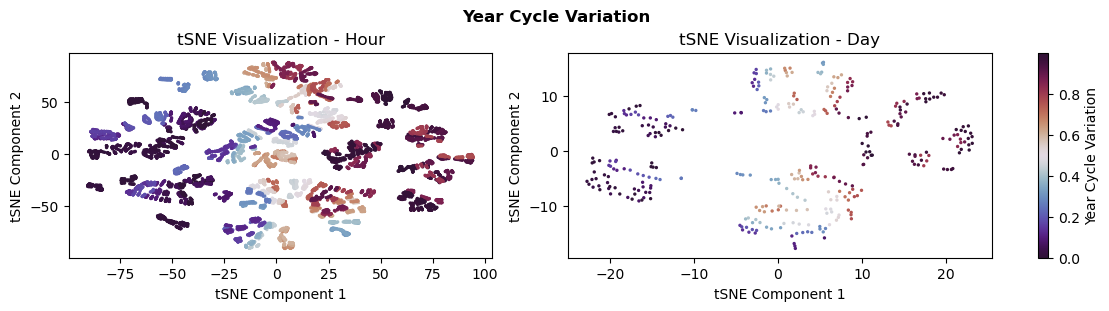

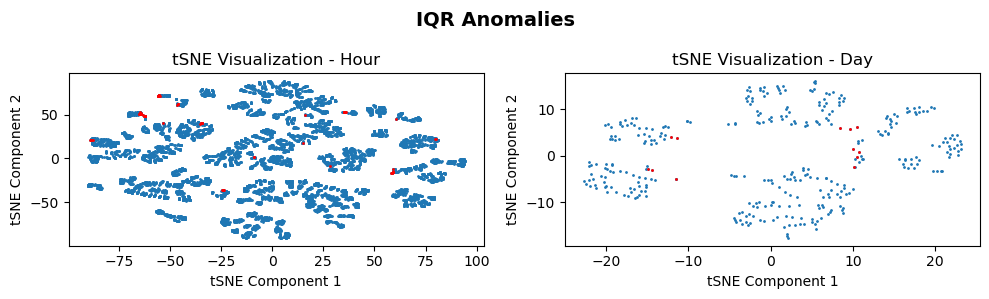

In [436]:
## t-SNE visualization
tSNE = TSNE(n_components=2, perplexity=30, random_state=42)
df_tSNE_min_max_hour = tSNE.fit_transform(df_hour_min_max)
df_tSNE_min_max_day = tSNE.fit_transform(df_day_min_max)

# Plot functions
def tSNE_min_max_Plot_Plain():
    fig, axes = plt.subplots(1,2,figsize=(10,3))
    # Hour
    axes[0].scatter(df_tSNE_min_max_hour[:, 0], df_tSNE_min_max_hour[:, 1],s=1) # c=labels
    axes[0].set_title("tSNE Visualization - Hour")
    axes[0].set_xlabel("tSNE Component 1")
    axes[0].set_ylabel("tSNE Component 2")
    # Day
    axes[1].scatter(df_tSNE_min_max_day[:, 0], df_tSNE_min_max_day[:, 1],s=1) # c=labels
    axes[1].set_title("tSNE Visualization - Day")
    axes[1].set_xlabel("tSNE Component 1")
    axes[1].set_ylabel("tSNE Component 2")
    plt.tight_layout()
    plt.show()

def tSNE_min_max_Plot_Color(suptitle='',color_param_hour='tab:blue',color_param_day='tab:blue'):
    fig, axes = plt.subplots(1,2,figsize=(11,3), constrained_layout=True)
    fig.suptitle(suptitle, fontsize=12, weight='bold')
    # Hour
    scatter_hour = axes[0].scatter(df_tSNE_min_max_hour[:, 0], df_tSNE_min_max_hour[:, 1],s=2,
                   c=color_param_hour, cmap='twilight_shifted') # c=labels
    axes[0].set_title("tSNE Visualization - Hour")
    axes[0].set_xlabel("tSNE Component 1")
    axes[0].set_ylabel("tSNE Component 2")
    # Day
    scatter_day = axes[1].scatter(df_tSNE_min_max_day[:, 0], df_tSNE_min_max_day[:, 1],s=2,
                   c=color_param_day, cmap='twilight_shifted') # c=labels
    axes[1].set_title("tSNE Visualization - Day")
    axes[1].set_xlabel("tSNE Component 1")
    axes[1].set_ylabel("tSNE Component 2") 
    fig.colorbar(scatter_hour,ax=axes, location='right').set_label(suptitle)
    plt.show()

def tSNE_min_max_Plot_Anomalies(suptitle, hour_anomalies,day_anomalies):
    ## Provide outliers as list of indexes using original data index   
    fig, axes = plt.subplots(1,2,figsize=(10,3))
    fig.suptitle(suptitle,fontsize=14, weight='bold')
    # Hour
    axes[0].scatter(df_tSNE_min_max_hour[:, 0], df_tSNE_min_max_hour[:, 1],s=1) # Regular
    axes[0].scatter(df_tSNE_min_max_hour[hour_anomalies, 0], df_tSNE_min_max_hour[hour_anomalies, 1],s=1, c='red') # Anomalies
    axes[0].set_title("tSNE Visualization - Hour")
    axes[0].set_xlabel("tSNE Component 1")
    axes[0].set_ylabel("tSNE Component 2")
    # Day
    axes[1].scatter(df_tSNE_min_max_day[:, 0], df_tSNE_min_max_day[:, 1],s=1) # Regular
    axes[1].scatter(df_tSNE_min_max_day[day_anomalies, 0], df_tSNE_min_max_day[day_anomalies, 1],s=1,c='red') # Anomalies
    axes[1].set_title("tSNE Visualization - Day")
    axes[1].set_xlabel("tSNE Component 1")
    axes[1].set_ylabel("tSNE Component 2")
    plt.tight_layout()
    plt.show()

## Plotting
tSNE_min_max_Plot_Plain()

tSNE_min_max_Plot_Color(suptitle='Weekday Variation',color_param_hour=df_hour_agg.iloc[df_hour_final.index].weekday,color_param_day=df_day_agg.iloc[df_day_final.index].weekday)
tSNE_min_max_Plot_Color(suptitle='Month Variation',color_param_hour=df_hour_agg.iloc[df_hour_final.index].month,color_param_day=df_day_agg.iloc[df_day_final.index].month)
tSNE_min_max_Plot_Color(suptitle='Year Cycle Variation',color_param_hour=df_hour_final.year_hour_cycle,color_param_day=df_day_final.year_day_cycle)

tSNE_min_max_Plot_Anomalies(suptitle='IQR Anomalies', hour_anomalies=hour_outliers_shifted,day_anomalies=day_outliers_shifted)

---
# 6. Modeling (Hyperparameter Tuning)


In [437]:
def model_evaluator(model, data):
    predictions = model.fit_predict(data) # Outliers labeled -1
    print(f'% Anomaly {round(100*np.sum(np.where(predictions < 0, 1, 0))/len(data),2)} %')
    predictions = pd.DataFrame(predictions)
    anomaly_indicies = np.where(predictions < 0)[0]
    return anomaly_indicies

### Hyperparameter Study

In [548]:
## OCSVM - min/max
# Gamma
hour_anomaly_percent = []
day_anomaly_percent = []
gammas = [0.00000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
for gamma in gammas:
    # hour_anomalies = OneClassSVM(kernel='rbf', gamma=gamma, nu=0.99).fit_predict(df_hour_min_max)
    # day_anomalies = OneClassSVM(kernel='rbf', gamma=gamma, nu=0.99).fit_predict(df_day_min_max)
    # hour_anomaly_percent.append(round(100*np.sum(np.where(hour_anomalies < 0, 1, 0))/len(df_hour_min_max),2))
    # day_anomaly_percent.append(round(100*np.sum(np.where(day_anomalies < 0, 1, 0))/len(df_day_min_max),2))
    hour_anomalies = OneClassSVM(kernel='rbf', gamma=gamma, nu=0.99).fit_predict(df_hour_standard)
    day_anomalies = OneClassSVM(kernel='rbf', gamma=gamma, nu=0.99).fit_predict(df_day_standard)
    hour_anomaly_percent.append(round(100*np.sum(np.where(hour_anomalies < 0, 1, 0))/len(df_hour_standard),2))
    day_anomaly_percent.append(round(100*np.sum(np.where(day_anomalies < 0, 1, 0))/len(df_day_standard),2))
df_gamma = pd.DataFrame()
df_gamma['gamma'] = gammas
df_gamma['hour_%_anomaly'] = hour_anomaly_percent
df_gamma['day_%_anomaly'] = day_anomaly_percent

In [446]:
## DBSCAN - standard
# Eps
hour_anomaly_percent = []
day_anomaly_percent = []
epses = [0.1, 0.5, 1, 1.1, 1.35, 1.5, 2, 5]
for eps in epses:
    hour_anomalies = DBSCAN(eps=eps).fit_predict(df_hour_standard)
    day_anomalies = DBSCAN(eps=eps).fit_predict(df_day_standard)
    hour_anomaly_percent.append(round(100*np.sum(np.where(hour_anomalies < 0, 1, 0))/len(df_hour_standard),2))
    day_anomaly_percent.append(round(100*np.sum(np.where(day_anomalies < 0, 1, 0))/len(df_day_standard),2))
df_eps = pd.DataFrame()
df_eps['eps'] = epses
df_eps['hour_%_anomaly'] = hour_anomaly_percent
df_eps['day_%_anomaly'] = day_anomaly_percent

In [485]:
## DBSCAN - standard
# Min_samples
hour_anomaly_percent = []
day_anomaly_percent = []
min_samples = np.arange(1,32,2)
for min_sample in min_samples:
    hour_anomalies = DBSCAN(eps=1,min_samples = min_sample).fit_predict(df_hour_standard)
    day_anomalies = DBSCAN(eps=1.5,min_samples = min_sample).fit_predict(df_day_standard)
    hour_anomaly_percent.append(round(100*np.sum(np.where(hour_anomalies < 0, 1, 0))/len(df_hour_standard),2))
    day_anomaly_percent.append(round(100*np.sum(np.where(day_anomalies < 0, 1, 0))/len(df_day_standard),2))
df_min_samples = pd.DataFrame()
df_min_samples['min_samples'] = min_samples
df_min_samples['hour_%_anomaly'] = hour_anomaly_percent
df_min_samples['day_%_anomaly'] = day_anomaly_percent

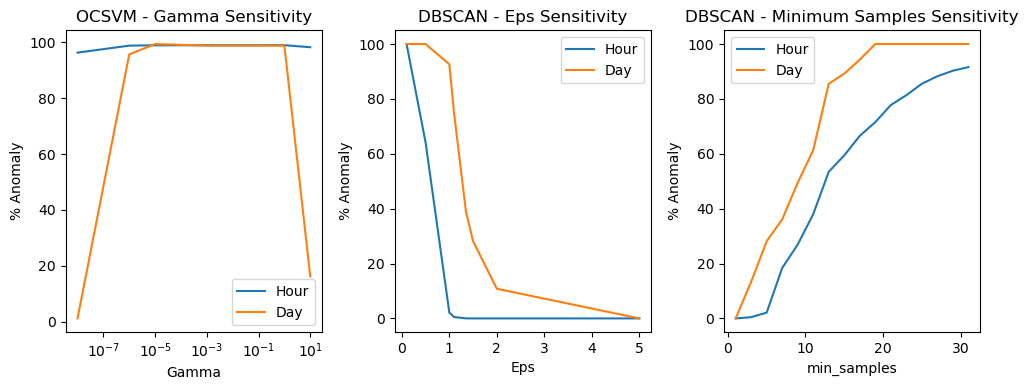

In [549]:
### Plotting
## Hourly Variation
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Plot 1: Gamma Sensitivity
axes[0].plot('gamma', 'hour_%_anomaly', data=df_gamma, label='Hour')
axes[0].plot('gamma', 'day_%_anomaly', data=df_gamma, label='Day')
axes[0].set_title("OCSVM - Gamma Sensitivity")
axes[0].set_xlabel("Gamma")
axes[0].set_ylabel("% Anomaly")
axes[0].set_xscale('log')
axes[0].legend()

# Plot 2: Eps Sensitivity
axes[1].plot('eps', 'hour_%_anomaly', data=df_eps, label='Hour')
axes[1].plot('eps', 'day_%_anomaly', data=df_eps, label='Day')
axes[1].set_title("DBSCAN - Eps Sensitivity")
axes[1].set_xlabel("Eps")
axes[1].set_ylabel("% Anomaly")
axes[1].legend()

# Plot 3: Min_samples Sensitivity
axes[2].plot('min_samples', 'hour_%_anomaly', data=df_min_samples, label='Hour')
axes[2].plot('min_samples', 'day_%_anomaly', data=df_min_samples, label='Day')
axes[2].set_title("DBSCAN - Minimum Samples Sensitivity")
axes[2].set_xlabel("min_samples")
axes[2].set_ylabel("% Anomaly")
axes[2].legend()

plt.tight_layout()
plt.show()

## 6.1 OneClass SVM

In [523]:
# ocsvm_anomalies_hour = model_evaluator(model=OneClassSVM(kernel='rbf', gamma=0.00000001, nu=0.5),data=df_hour_min_max)
ocsvm_anomalies_hour = model_evaluator(model=OneClassSVM(kernel='rbf', gamma=0.000000001, nu=0.5),data=df_hour_standard)

% Anomaly 13.81 %


In [527]:
# ocsvm_anomalies_day = model_evaluator(model=OneClassSVM(kernel='rbf', gamma=0.0000001, nu=0.5),data=df_day_min_max)
ocsvm_anomalies_day = model_evaluator(model=OneClassSVM(kernel='rbf', gamma=0.00000015, nu=0.5),data=df_day_standard)

% Anomaly 10.8 %


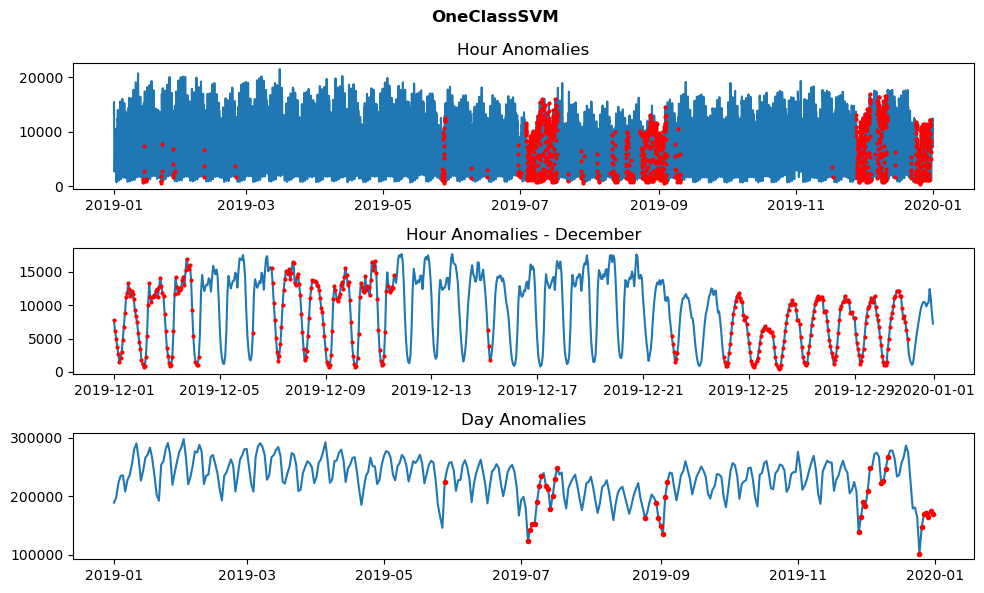

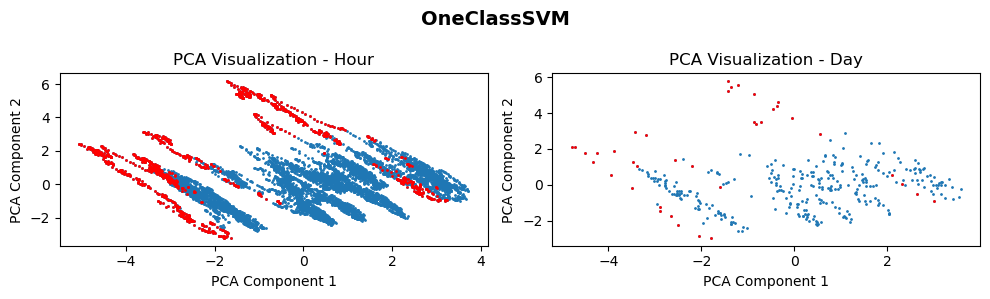

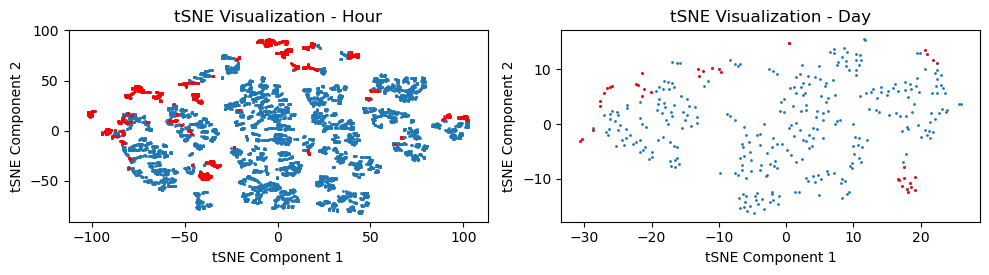

In [562]:
anomaly_plot(suptitle="OneClassSVM", hour_anomalies=ocsvm_anomalies_hour, day_anomalies=ocsvm_anomalies_day)
# PCA_min_max_Plot_Anomalies(suptitle='OneClassSVM', hour_anomalies=ocsvm_anomalies_hour,day_anomalies=ocsvm_anomalies_day)
# tSNE_min_max_Plot_Anomalies(suptitle='OneClassSVM', hour_anomalies=ocsvm_anomalies_hour,day_anomalies=ocsvm_anomalies_day)
PCA_standard_Plot_Anomalies(suptitle='OneClassSVM', hour_anomalies=ocsvm_anomalies_hour,day_anomalies=ocsvm_anomalies_day)
tSNE_standard_Plot_Anomalies(suptitle='', hour_anomalies=ocsvm_anomalies_hour,day_anomalies=ocsvm_anomalies_day)

## 6.2 DBSCAN

In [530]:
dbscan_anomalies_hour = model_evaluator(model=DBSCAN(eps=0.85),data=df_hour_standard)

% Anomaly 11.76 %


In [560]:
dbscan_anomalies_day = model_evaluator(model=DBSCAN(eps=1.85),data=df_day_standard)

% Anomaly 13.35 %


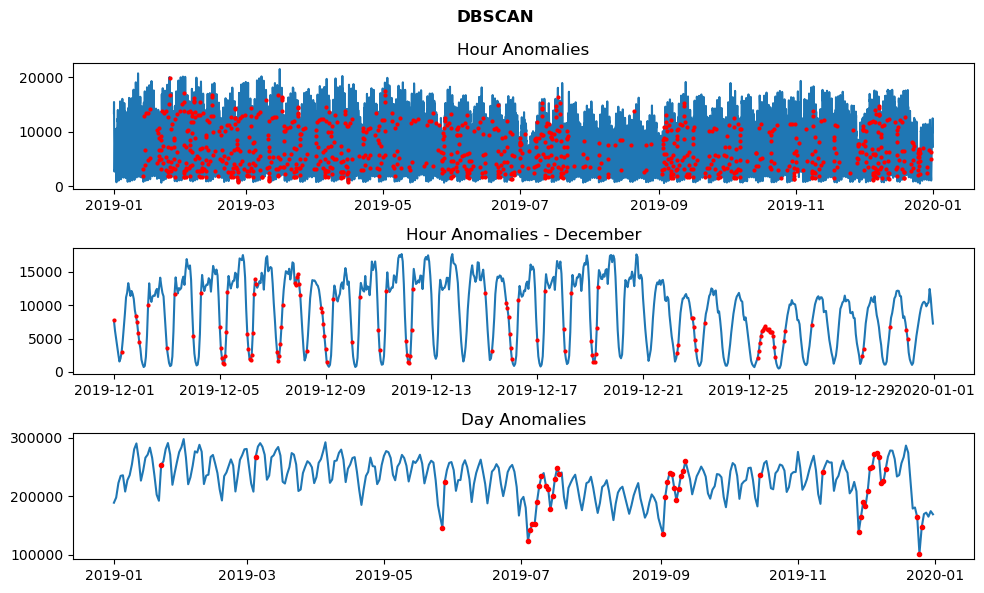

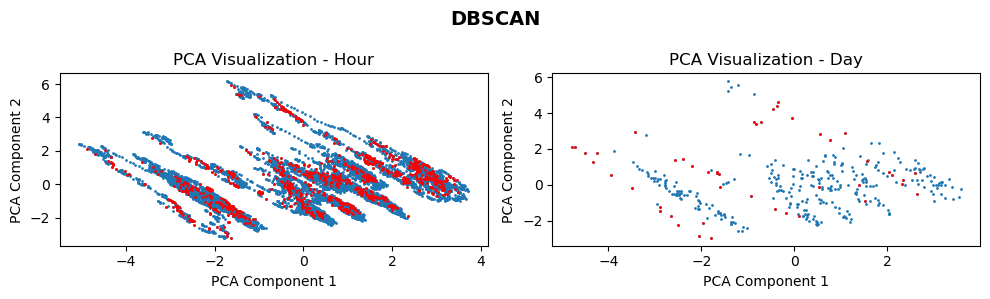

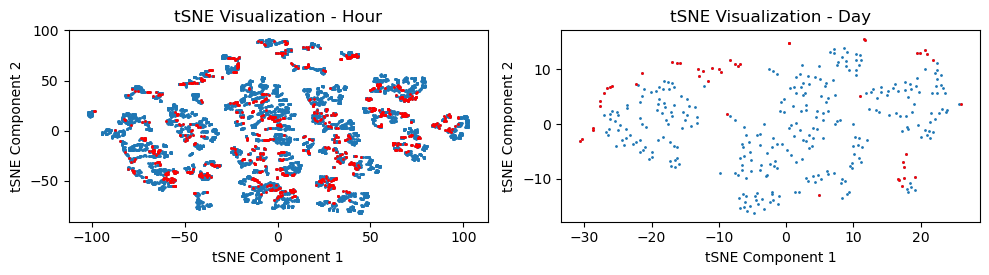

In [563]:
anomaly_plot(suptitle="DBSCAN", hour_anomalies=dbscan_anomalies_hour, day_anomalies=dbscan_anomalies_day)
# PCA_min_max_Plot_Anomalies(suptitle='DBSCAN', hour_anomalies=dbscan_anomalies_hour,day_anomalies=dbscan_anomalies_day)
# tSNE_min_max_Plot_Anomalies(suptitle='DBSCAN', hour_anomalies=dbscan_anomalies_hour,day_anomalies=dbscan_anomalies_day)
PCA_standard_Plot_Anomalies(suptitle='DBSCAN', hour_anomalies=dbscan_anomalies_hour,day_anomalies=dbscan_anomalies_day)
tSNE_standard_Plot_Anomalies(suptitle='', hour_anomalies=dbscan_anomalies_hour,day_anomalies=dbscan_anomalies_day)

## 6.3 Autoencoder

In [449]:
def build_autoencoder(input_dim, latent_dim, data, epochs=25, batch_size=32):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(64, activation='relu')(input_layer)
    encoder = Dense(32, activation='relu')(encoder)
    encoder = Dense(latent_dim, activation='relu')(encoder)

    # Decoder
    decoder = Dense(32, activation='relu')(encoder)
    decoder = Dense(64, activation='relu')(decoder)
    decoder = Dense(input_dim, activation='sigmoid')(decoder)

    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoder)

    # Define reconstruction loss
    def reconstruction_loss(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))  # Mean squared error

    # Compile the model
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=reconstruction_loss)

    # Train the autoencoder
    log = autoencoder.fit(data, data, epochs=epochs, batch_size=batch_size, verbose=0)

    return autoencoder, log

### 6.3.1 Daily

In [450]:
print("df_day_min_max.shape", df_day_min_max.shape)

df_day_min_max.shape (352, 10)


In [451]:
autoencoder_day, log_day = build_autoencoder(input_dim=10, latent_dim=4, data=df_day_min_max)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


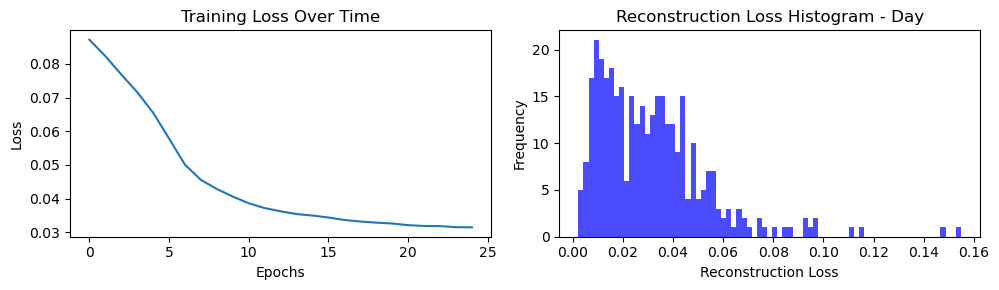

In [551]:
# Reconstruction from final model
reconstructed_day = autoencoder_day.predict(df_day_min_max)  # Reconstruct the test set
reconstruction_loss_day = np.mean(np.square(df_day_min_max - reconstructed_day), axis=1)

## Plot loss vs. epoch
fig, axes = plt.subplots(1,2,figsize=(10,3))
axes[0].plot(log_day.history['loss'])
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Over Time')

# Plot histogram of reconstruction losses
axes[1].hist(reconstruction_loss_day, bins=75, color='blue', alpha=0.7)
axes[1].set_xlabel('Reconstruction Loss')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Reconstruction Loss Histogram - Day')

plt.tight_layout()
plt.show()

In [552]:
threshold_day = 0.055  # Adjust threshold based on your data
# Find indices where reconstruction loss exceeds the threshold
auto_anomalies_day = np.where(reconstruction_loss_day > threshold_day)[0]
print(f'% Anomaly {round(100*len(auto_anomalies_day)/len(df_day_min_max),2)} %')

% Anomaly 10.8 %


### 6.3.2 Hour

In [454]:
print("df_hour_min_max.shape", df_hour_min_max.shape)

df_hour_min_max.shape (8424, 12)


In [455]:
autoencoder_hour, log_hour = build_autoencoder(input_dim=12, latent_dim=6, data=df_hour_min_max, epochs=50)

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


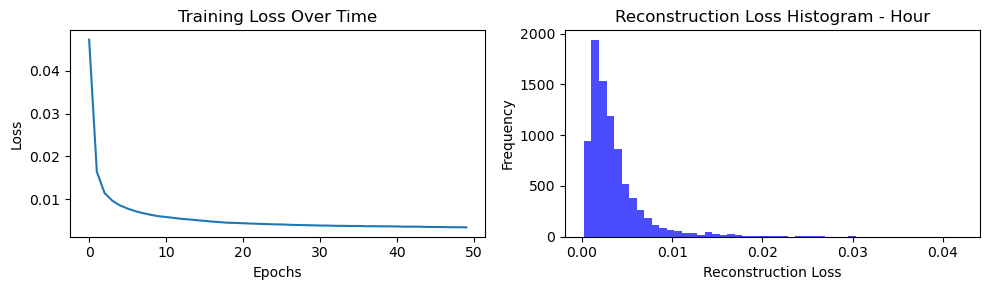

In [553]:
# Reconstruction from final model
reconstructed_hour = autoencoder_hour.predict(df_hour_min_max)  # Reconstruct the test set
reconstruction_loss_hour = np.mean(np.square(df_hour_min_max - reconstructed_hour), axis=1)

## Plot loss vs. epoch
fig, axes = plt.subplots(1,2,figsize=(10,3))
axes[0].plot(log_hour.history['loss'])
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Over Time')

# Plot histogram of reconstruction losses
axes[1].hist(reconstruction_loss_hour, bins=50, color='blue', alpha=0.7)
axes[1].set_xlabel('Reconstruction Loss')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Reconstruction Loss Histogram - Hour')

plt.tight_layout()
plt.show()

In [535]:
threshold_hour = 0.006  # Adjust threshold based on your data
# Find indices where reconstruction loss exceeds the threshold
auto_anomalies_hour = np.where(reconstruction_loss_hour > threshold_hour)[0]
print(f'% Anomaly {round(100*len(auto_anomalies_hour)/len(df_hour_min_max),2)} %')

% Anomaly 12.83 %


### 6.3.3 Plotting Autoencoder Anomalies

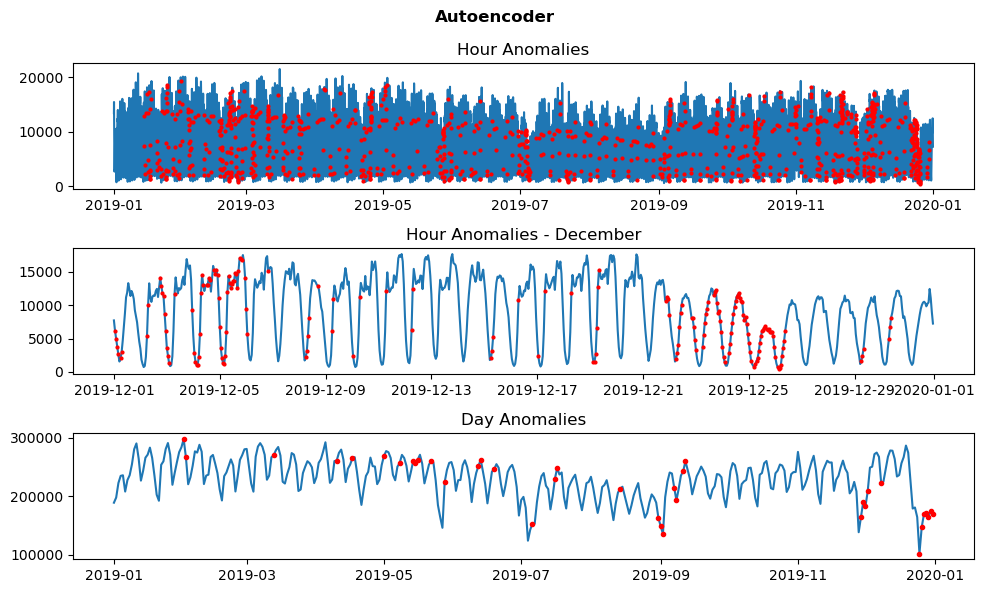

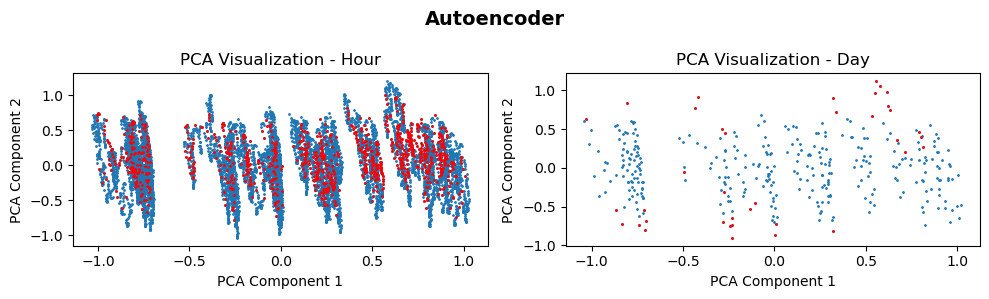

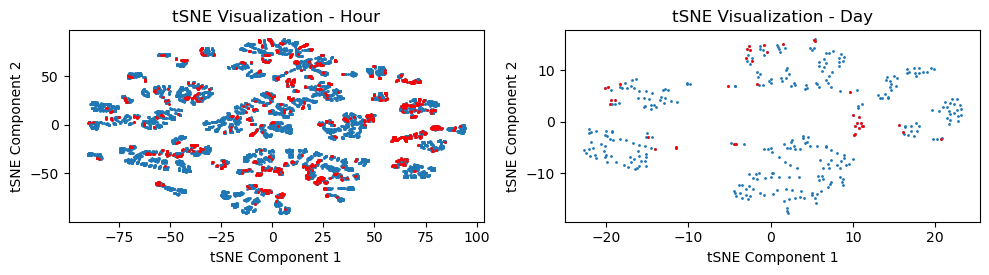

In [564]:
anomaly_plot(suptitle="Autoencoder", hour_anomalies=auto_anomalies_hour, day_anomalies=auto_anomalies_day)
PCA_min_max_Plot_Anomalies(suptitle='Autoencoder', hour_anomalies=auto_anomalies_hour,day_anomalies=auto_anomalies_day)
tSNE_min_max_Plot_Anomalies(suptitle='', hour_anomalies=auto_anomalies_hour,day_anomalies=auto_anomalies_day)

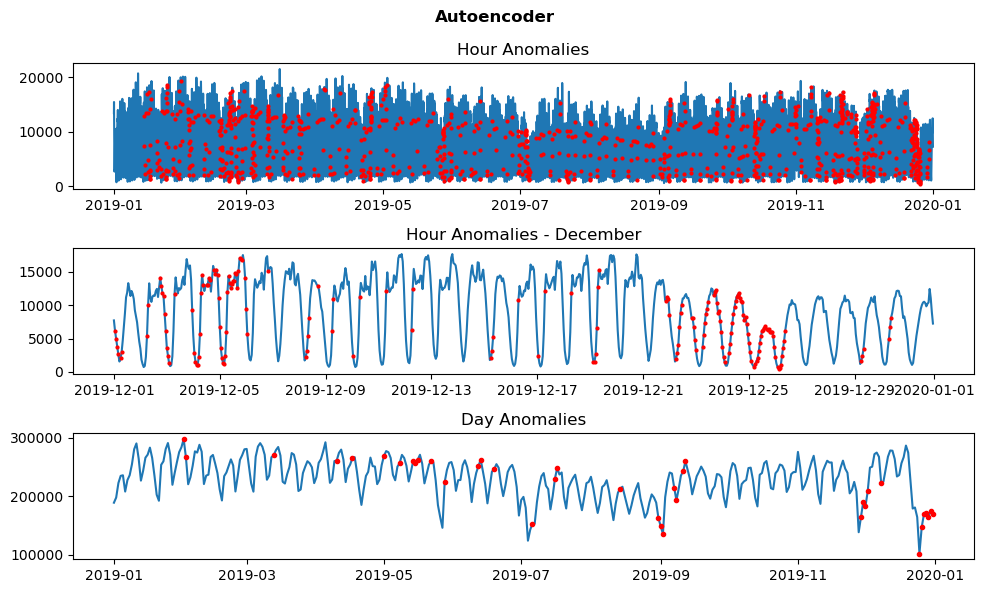

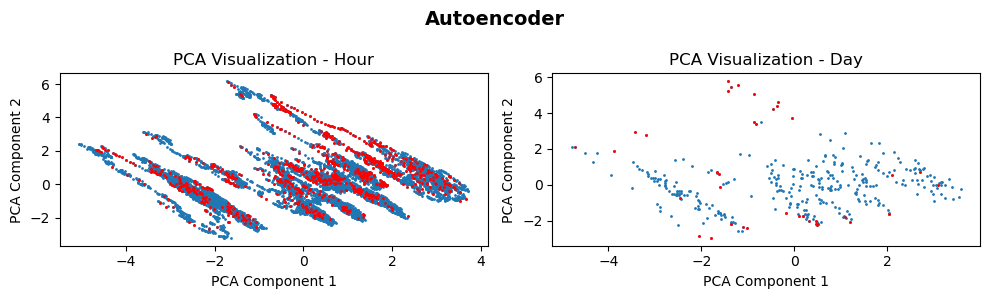

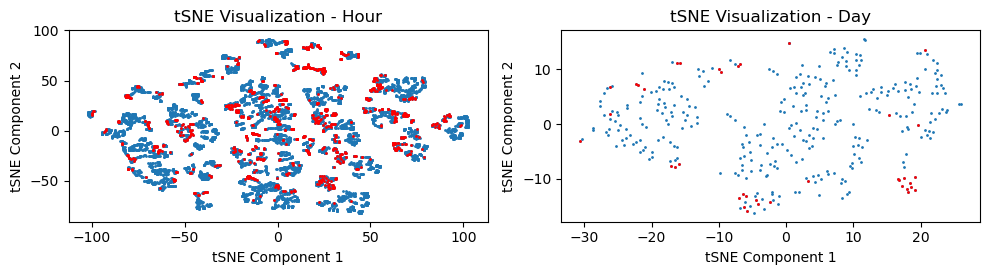

In [565]:
anomaly_plot(suptitle="Autoencoder", hour_anomalies=auto_anomalies_hour, day_anomalies=auto_anomalies_day)
PCA_standard_Plot_Anomalies(suptitle='Autoencoder', hour_anomalies=auto_anomalies_hour,day_anomalies=auto_anomalies_day)
tSNE_standard_Plot_Anomalies(suptitle='', hour_anomalies=auto_anomalies_hour,day_anomalies=auto_anomalies_day)

## 6.4 Evaluating Against Statistical Outliers


In [537]:
# hour_outliers_shifted
hour_outlier_percent = []
hour_outlier_percent.append(round(100*len(set(list(ocsvm_anomalies_hour))&(set(list(hour_outliers_shifted))))/len(hour_outliers_shifted),2))
hour_outlier_percent.append(round(100*len(set(list(dbscan_anomalies_hour))&(set(list(hour_outliers_shifted))))/len(hour_outliers_shifted),2))
hour_outlier_percent.append(round(100*len(set(list(auto_anomalies_hour))&(set(list(hour_outliers_shifted))))/len(hour_outliers_shifted),2))

In [538]:
# day_outliers_shifted
day_outlier_percent = []
day_outlier_percent.append(round(100*len(set(list(ocsvm_anomalies_day))&(set(list(day_outliers_shifted))))/len(day_outliers_shifted),2))
day_outlier_percent.append(round(100*len(set(list(dbscan_anomalies_day))&(set(list(day_outliers_shifted))))/len(day_outliers_shifted),2))
day_outlier_percent.append(round(100*len(set(list(auto_anomalies_day))&(set(list(day_outliers_shifted))))/len(day_outliers_shifted),2))

In [539]:
df_outlier_percent = pd.DataFrame({"Model":['OCSVM','DBSCAM','Autoencoder'],"Hour Outlier %":hour_outlier_percent, "Day Outlier %":day_outlier_percent})
df_outlier_percent

Model  Hour Outlier %  Day Outlier %
0        OCSVM           70.27          83.33
1       DBSCAM           14.86          91.67
2  Autoencoder           14.86          58.33

---
# 7. Feature Importance
Feature importance will be evaluated by applying a random forest classifier to the predictions provided by the 

In [540]:
def Feature_Importance_Extraction(label,data,anomalies_index):
    predictions = np.zeros(len(data))
    predictions[anomalies_index] = 1

    # Initialize and train Random Forest classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(data, predictions)
    
    # Extract feature importance
    feature_importance = rf.feature_importances_
    # print(feature_importance)
    sorted_indices = np.argsort(feature_importance)[::-1]  # Sort features by importance
    if 'day' in label:
        features = df_day_final.columns[sorted_indices]
    else:
        features = df_hour_final.columns[sorted_indices]
    return features, feature_importance[sorted_indices]

In [541]:
ocsvm_features, ocsvm_importance = Feature_Importance_Extraction(label="OCSVM Day Agg.",data=df_day_min_max, anomalies_index=ocsvm_anomalies_day)
dbscan_features, dbscan_importance =  Feature_Importance_Extraction(label="DBSCAN Day Agg.",data=df_day_standard, anomalies_index=dbscan_anomalies_day)
auto_features, auto_importance =  Feature_Importance_Extraction(label="Autoencoder Day Agg.",data=df_day_min_max, anomalies_index=auto_anomalies_day)

In [542]:
df_ocsvm_importance = pd.DataFrame({'Features':ocsvm_features,'OCSVM Importance':ocsvm_importance})
df_dbscan_importance = pd.DataFrame({'Features':dbscan_features,'DBSCAN Importance':dbscan_importance})
df_auto_importance = pd.DataFrame({'Features':auto_features,'Auto Importance':auto_importance})
df_day_importance = df_ocsvm_importance.merge(df_dbscan_importance, on='Features')
df_day_importance = df_day_importance.merge(df_auto_importance, on='Features')
df_day_importance['Average Importance'] = df_day_importance[['OCSVM Importance','DBSCAN Importance','Auto Importance']].mean(axis=1)
df_day_importance.sort_values('Average Importance', ascending=False, inplace=True)
df_day_importance

Features  OCSVM Importance  DBSCAN Importance  \
0    1_day_rate_of_change          0.292651           0.294577   
1   1_day_rolling_average          0.255890           0.140437   
2   7_day_rolling_average          0.155483           0.168814   
3                   count          0.137159           0.087800   
4        year_month_cycle          0.045932           0.085727   
5  14_day_rolling_average          0.045217           0.101618   
7       year_season_cycle          0.022153           0.027159   
6               day_cycle          0.033806           0.054944   
8    7_day_rate_of_change          0.006388           0.005245   
9              week_cycle          0.005320           0.033678   

   Auto Importance  Average Importance  
0         0.170927            0.252718  
1         0.131966            0.176098  
2         0.098954            0.141084  
3         0.153078            0.126013  
4         0.140027            0.090562  
5         0.070143            0.072326  
7         0.091393            0.046902  
6         0.050186            0.046312  
8         0.073532            0.028388  
9         0.019793            0.019597

<Axes: title={'center': 'Feature Importance - Day Aggregate'}, xlabel='Features'>

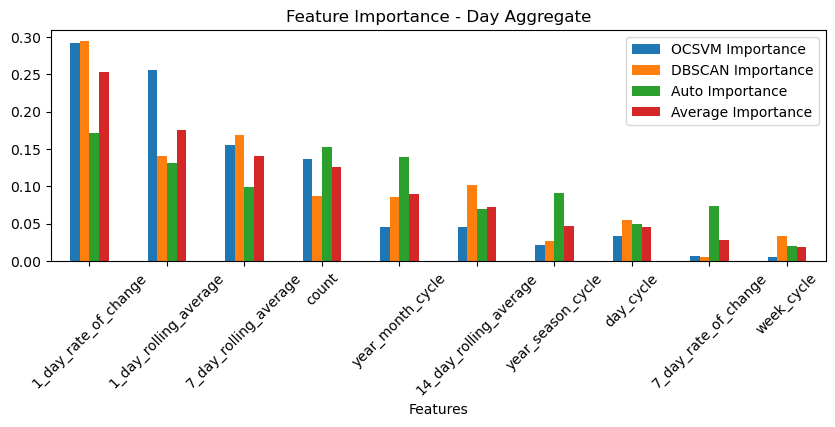

In [557]:
df_day_importance.plot.bar(x='Features',figsize=(10,3), rot=45, title='Feature Importance - Day Aggregate')

In [544]:
ocsvm_features, ocsvm_importance = Feature_Importance_Extraction(label="OCSVM Hour Agg.",data=df_hour_min_max, anomalies_index=ocsvm_anomalies_hour)
dbscan_features, dbscan_importance =  Feature_Importance_Extraction(label="DBSCAN Hour Agg.",data=df_hour_standard, anomalies_index=dbscan_anomalies_hour)
auto_features, auto_importance =  Feature_Importance_Extraction(label="Autoencoder Hour Agg.",data=df_hour_min_max, anomalies_index=auto_anomalies_hour)

In [545]:
df_ocsvm_importance = pd.DataFrame({'Features':ocsvm_features,'OCSVM Importance':ocsvm_importance})
df_dbscan_importance = pd.DataFrame({'Features':dbscan_features,'DBSCAN Importance':dbscan_importance})
df_auto_importance = pd.DataFrame({'Features':auto_features,'Auto Importance':auto_importance})
df_hour_importance = df_ocsvm_importance.merge(df_dbscan_importance, on='Features')
df_hour_importance = df_hour_importance.merge(df_auto_importance, on='Features')
df_hour_importance['Average Importance'] = df_hour_importance[['OCSVM Importance','DBSCAN Importance','Auto Importance']].mean(axis=1)
df_hour_importance.sort_values('Average Importance', ascending=False, inplace=True)
df_hour_importance

Features  OCSVM Importance  DBSCAN Importance  \
7                    count          0.031682           0.208677   
0    7_day_rolling_average          0.233863           0.079232   
1     7_day_rate_of_change          0.222154           0.089052   
2   14_day_rolling_average          0.175776           0.081764   
3    1_day_rolling_average          0.121062           0.109359   
5     1_day_rate_of_change          0.048504           0.102218   
10               day_cycle          0.008449           0.119809   
4          year_hour_cycle          0.081519           0.077107   
11              week_cycle          0.005592           0.050621   
8              month_cycle          0.024232           0.048301   
6         year_month_cycle          0.035990           0.022421   
9        year_season_cycle          0.011178           0.011439   

    Auto Importance  Average Importance  
7          0.185606            0.141989  
0          0.077420            0.130171  
1          0.073795            0.128334  
2          0.070729            0.109423  
3          0.087689            0.106037  
5          0.130616            0.093779  
10         0.136423            0.088227  
4          0.076783            0.078470  
11         0.083126            0.046446  
8          0.045793            0.039442  
6          0.022956            0.027122  
9          0.009064            0.010560

<Axes: title={'center': 'Feature Importance - Hour Aggregate'}, xlabel='Features'>

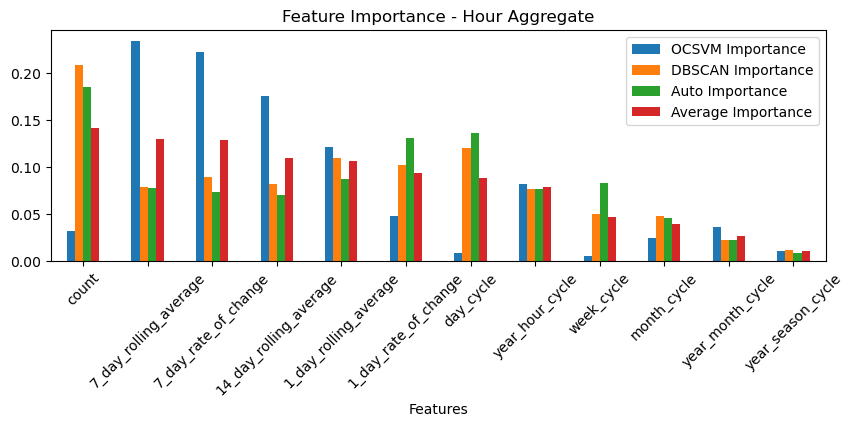

In [556]:
df_hour_importance.plot.bar(x='Features',figsize=(10,3), rot=45, title='Feature Importance - Hour Aggregate')